# **CBIR**

## **0. Librerías**

In [1]:
# !pip install lshashpy3
#!pip install future

  Preparing metadata (setup.py) ... done
  Created wheel for lshashpy3: filename=lshashpy3-0.0.8-py3-none-any.whl size=8884 sha256=7cc148a13dc66002bd016b88c761fb68341890a1724f87534dccd8a402fb5555
  Stored in directory: /root/.cache/pip/wheels/c5/d8/e4/5d908300e0a9cbfa801da1fab413132b9341cabd73a2873aef
Successfully built lshashpy3


In [2]:
import pickle
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
import time
from itertools import chain

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lshashpy3 import LSHash

# Google file system
# from google.colab import files, drive

In [3]:
# drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## **1. Adquisión de datos y selección del dataset**

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
diccionario_cifar10=unpickle(("./cifar10/data_batch_1"))
# Obtener datos y etiquetas
datos = diccionario_cifar10[b'data']
etiquetas = diccionario_cifar10[b'labels']
# Convertir los datos a un formato adecuado para la visualización (por ejemplo, 32x32x3 para imágenes CIFAR-10)
datos_reshaped = datos.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

In [6]:
# Función para visualizar varias imágenes
def mostrar_imagenes(images, etiquetas, cantidad=10):
    plt.figure(figsize=(15, 7))
    for i in range(cantidad):
        plt.subplot(5, 10, i + 1)
        plt.imshow(images[i])
        plt.title(f"{etiquetas[i]}")
        plt.axis('off')
    plt.show()

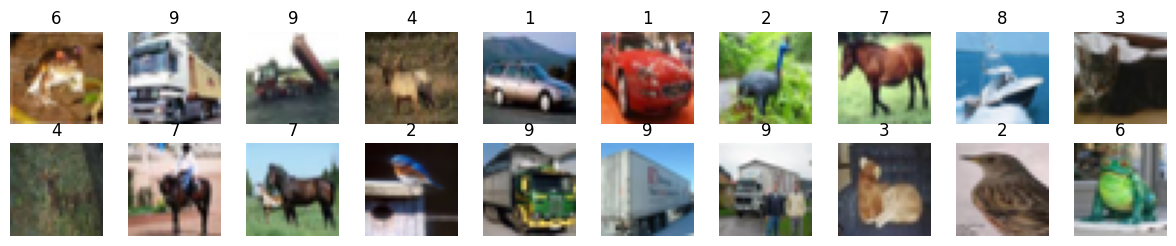

In [7]:
# Mostrar algunas imágenes
mostrar_imagenes(datos_reshaped, etiquetas, cantidad=20)

### **1.1. Selección de un subconjunto de imágenes**

Como nos vienen 10 clases con 1000 imágenes de cada clase, vamos a reducir nuestro conjunto de dataset a 100 imágenes por clase.

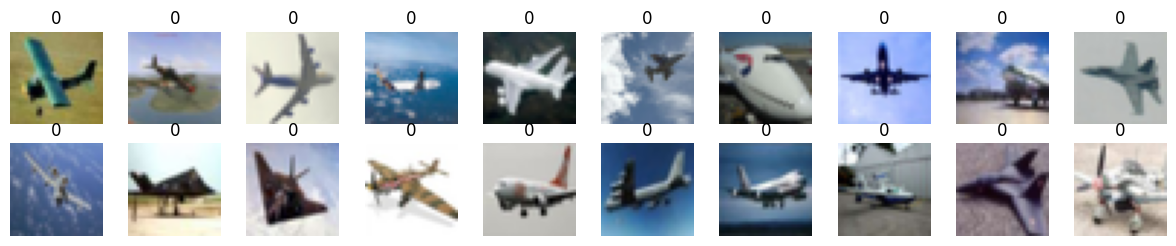

In [8]:
# Establecer la semilla para reproducibilidad
np.random.seed(42)

# Seleccionar aleatoriamente 100 imágenes de cada clase
num_imagenes_por_clase = 100
imagenes_seleccionadas = []
etiquetas_seleccionadas = []

indices_img_seleccionadas = []  # se usa después para definir imágenes de test

for clase in range(10):
    indices_clase = np.where(np.array(etiquetas) == clase)[0]
    indices_seleccionados = np.random.choice(indices_clase, num_imagenes_por_clase, replace=False)
    imagenes_seleccionadas.extend(datos_reshaped[indices_seleccionados])
    etiquetas_seleccionadas.extend([clase] * num_imagenes_por_clase)

# Mostrar las imágenes seleccionadas
mostrar_imagenes(imagenes_seleccionadas, etiquetas_seleccionadas, cantidad=20)

Ahora que ya tenemos las imágenes de cada clase ordenadas, vamos a ver qué clases tenemos obsevando una imagen de cada clase.

In [9]:
def mostrar_una_imagen_por_clase(datos, etiquetas):
    clases_unicas = np.unique(etiquetas)

    plt.figure(figsize=(15, 7))
    for i, clase in enumerate(clases_unicas):
        indice_clase = np.where(np.array(etiquetas) == clase)[0][0]
        plt.subplot(1, len(clases_unicas), i + 1)
        plt.imshow(datos[indice_clase])
        plt.title(f"Clase: {clase}")
        plt.axis('off')
    plt.show()

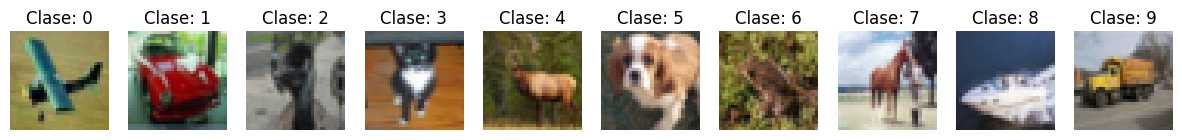

In [10]:
mostrar_una_imagen_por_clase(imagenes_seleccionadas, etiquetas_seleccionadas)

En efecto, tenemos las clases que se nos indicaban en la referencia: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión.

**Guardado de las imágenes seleccionadas**: guaradamos las 1000 imágenes que hemos seleccionado que se usarán en la interfaz gráfica (para no realizar la selección de imágenes pcada que se ejecuta la interfaz).

*Nota: cambiamos las etiquetas de números por texto.*

In [11]:
mapeo_numeros_a_nombres = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [12]:
# Crear un diccionario con las imágenes y etiquetas seleccionadas
diccionario_guardado = {
    'imagenes': imagenes_seleccionadas,
    'etiquetas': [mapeo_numeros_a_nombres[numero] for numero in etiquetas_seleccionadas]
}

# Guardar el diccionario en un archivo pickle
with open('imagenes_seleccionadas.pickle', 'wb') as f:
    pickle.dump(diccionario_guardado, f)

print('Ok guardado')

# Cargar el diccionario desde el archivo pickle
with open('imagenes_seleccionadas.pickle', 'rb') as f:
    diccionario_cargado = pickle.load(f)

# Acceder a las imágenes y etiquetas
imagenes_seleccionadas = diccionario_cargado['imagenes']
etiquetas_seleccionadas = diccionario_cargado['etiquetas']
print('Ok cargado')

Ok guardado
Ok cargado


### **1.2. Selección de un subconjunto de imágenes de test**

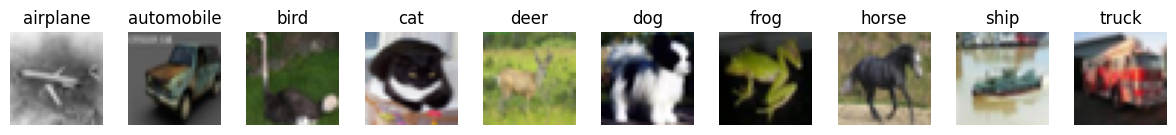

In [13]:
# Establecer la semilla para reproducibilidad
np.random.seed(7)

# Seleccionar aleatoriamente 1 imagen de cada clase que no esté en imagenes_seleccionadas
imagenes_test = []  # Almacenará las imágenes test
etiquetas_test_num = []  # Almacenará las etiquetas test

# Recorre cada clase
for clase in range(10):
    # Encuentra los índices de todas las imágenes de la clase actual
    indices_clase = np.where(np.array(etiquetas) == clase)[0]

    # Filtra los índices que no están en imagenes_seleccionadas
    indices_no_seleccionados = [i for i in indices_clase if i not in indices_img_seleccionadas]

    # Si hay al menos una imagen no seleccionada, elige una al azar
    if indices_no_seleccionados:
        indice_seleccionado = np.random.choice(indices_no_seleccionados, 1)[0]
        imagen_seleccionada = datos_reshaped[indice_seleccionado]

        # Agrega la imagen y la etiqueta a las listas correspondientes
        imagenes_test.append(imagen_seleccionada)
        etiquetas_test_num.append(clase)

etiquetas_test = [mapeo_numeros_a_nombres[numero] for numero in etiquetas_test_num]
# Mostrar las imágenes faltantes
mostrar_imagenes(imagenes_test, etiquetas_test, cantidad=10)

## **2. Extracción de características**

### **2.1 Histograma de color**

Visualizamos histogramas de color de una imagen de cada clase

#### Función 3: visualizar histogramas de color de una sola imagen

Una función que toma parámetro de entrada una imagen y nos muestra los histogramas de color de la imagen

In [ ]:
def build_hist(image, bins=256):
    plt.imshow(image)  # pintamos la imagen de entrada
    canales = cv2.split(image)
    hist_r = cv2.calcHist(canales, [0], None, [256], [0, 256])
    hist_g = cv2.calcHist(canales, [1], None, [256], [0, 256])
    hist_b = cv2.calcHist(canales, [2], None, [256], [0, 256])

    # pintamos los histogramas de color
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axs[0].plot(hist_r, color='r')
    axs[1].plot(hist_g, color='g')
    axs[2].plot(hist_b, color='b')
    plt.show()

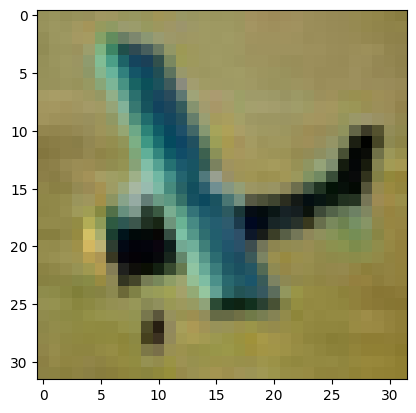

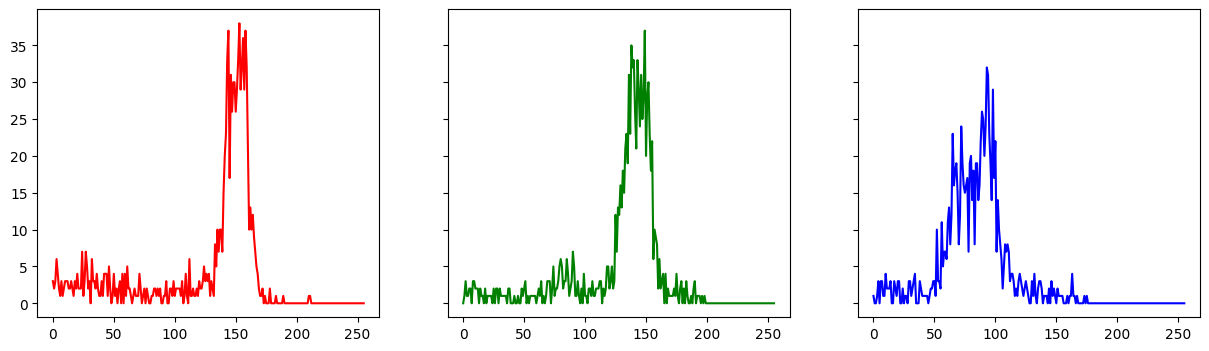

In [ ]:
build_hist(imagenes_seleccionadas[0])  # primera imagen

#### Función 4: Extracción de Histograma de color

Función que toma como entrada una imagen y nos devuelve todos los histogramas de color (rojo, verde y azul) concatenados. Primero, saca los histogramas de color usando la función calcHist de OpenCV. Después, normaliza estos histogramas y, finalmente, los cancatena.

In [38]:
def calcular_histograma_color(imagen):
    canales = cv2.split(imagen)
    hist_r = cv2.calcHist(canales, [2], None, [256], [0, 256])
    hist_g = cv2.calcHist(canales, [1], None, [256], [0, 256])
    hist_b = cv2.calcHist(canales, [0], None, [256], [0, 256])
    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()
    return np.concatenate((hist_r, hist_g, hist_b))

#### Función 5: calcular todos histogramas y guardarlos

Se calcularán los histogramas de color de cada una de las imágenes seleccionadas y se meterán guardarán en un csv para su posterior utilización.

In [39]:
def guardar_histogramas_color(imagenes, nombre_fichero):
    histogramas_base_de_datos = []

    tiempo_inicial = time.time()
    for imagen in imagenes:
        hist_base_de_datos = calcular_histograma_color(imagen)
        histograma_aplanado = hist_base_de_datos.ravel()  # Aplanar el histograma
        histogramas_base_de_datos.append(histograma_aplanado)

    tiempo_final = time.time()
    # Calcula el tiempo de ejecución
    tiempo_ejecucion = tiempo_final - tiempo_inicial

    print(f"Tiempo de extracción de todos histogramas: {tiempo_ejecucion} segundos")

    # Convertir la lista de histogramas en un DataFrame de pandas
    df = pd.DataFrame(histogramas_base_de_datos)

    # Guardar el DataFrame en un archivo CSV
    df.to_csv(nombre_fichero, index=False)

In [40]:
# Descomentarlo para ejecutarlo si no tenemos el archivo
# guardar_histogramas_color(imagenes_seleccionadas, 'histogramas_color.csv')

Tiempo de extracción de todos histogramas: 0.07534337043762207 segundos


### **2.2 Histograma de textura**

#### **Extracción de características de textura**

In [47]:
#calcular caracteristicas de textura de una imagen
from skimage.feature import greycomatrix, greycoprops
import numpy as np

def caract_text(image):
    # Supongamos que 'imagen' es la imagen para la cual deseas calcular el histograma de textura
    # Convierte la imagen a escala de grises si aún no lo está
    img_gris = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Calcula la matriz de co-ocurrencia de niveles de gris
    distancias = [1]  # Distancia entre píxeles
    ángulos = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Ángulos de dirección
    glcm = greycomatrix(img_gris, distancias, angles=ángulos, symmetric=True, normed=True)

    # Calcula propiedades de textura a partir de la matriz GLCM
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    textura = np.array([greycoprops(glcm, prop) for prop in props])

    # El vector 'textura' contiene las características de textura de la imagen
    # textura_promedio = np.mean(textura, axis=1)  # Esto calculará el promedi
    return textura

#### **Guardado de características de texturas**

In [48]:
def guardar_caract_text(imagenes, nombre_fichero):
    texturas_bd = []

    tiempo_inicial = time.time()
    for imagen in imagenes:
        text_base_datos = caract_text(imagen)
        textura_aplanado = text_base_datos.ravel()
        texturas_bd.append(textura_aplanado)

    tiempo_final = time.time()
    # Calcula el tiempo de ejecución
    tiempo_ejecucion = tiempo_final - tiempo_inicial

    print(f"Tiempo de extracción de todos histogramas: {tiempo_ejecucion} segundos")

    # Convertir la lista de histogramas en un DataFrame de pandas
    df = pd.DataFrame(texturas_bd)

    # Guardar el DataFrame en un archivo CSV
    df.to_csv(nombre_fichero, index=False)

In [49]:
# Descomentarlo para ejecutarlo si no tenemos el archivo
# guardar_caract_text(imagenes_seleccionadas, 'caracts_textura.csv')

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_ve

Tiempo de extracción de todos histogramas: 50.72701954841614 segundos


### **2.3 Descriptores SIFT**

In [50]:
def sift(imagen):
    sift = cv2.SIFT_create()
    descriptor = None

    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)

    # Calcular los puntos clave y descriptores SIFT
    kp, des = sift.detectAndCompute(imagen_gris, None)

    if des is not None and len(des) > 0:
        # Encontrar el índice del descriptor con la mayor respuesta
        indice_descriptor_mas_importante = np.argmax([kp.response for kp in kp])

        # Obtener el descriptor más importante
        descriptor = des[indice_descriptor_mas_importante]
    else:
        print('No se han encontrado descriptores')

    return descriptor

In [51]:
def guardar_des_sift(imagenes, nombre_fichero):
    todos_descriptores = []
    inicio = time.time()
    for imagen in imagenes_seleccionadas:
        descriptor = sift(imagen)
        if descriptor is not None:
            todos_descriptores.append(descriptor)

    final = time.time()
    tiempo_ejecucion = final - inicio
    print(f"Tiempo de extracción de características: {tiempo_ejecucion} segundos")

    df = pd.DataFrame(todos_descriptores)
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(nombre_fichero, index=False)

In [52]:
# Descomentarlo para ejecutarlo si no tenemos el archivo
# guardar_des_sift(imagenes_seleccionadas, 'descriptores_sift.csv')

Tiempo de extracción de características: 2.0650553703308105 segundos


### **2.4 Redes CNN pre-entrenadas**

#### **2.4.1. VGG19**

##### **Función: extraer características con VGG19**

In [53]:
def vgg19():
    base_model = VGG19(weights='imagenet', include_top=False)
    return base_model

In [54]:
# Función para cargar y preprocesar imágenes según VGG19
def cargar_y_preprocesar_imagen(imagen):
    imagen = cv2.resize(imagen, (224, 224))  # Ajustar al tamaño de entrada de VGG19
    imagen = np.expand_dims(imagen, axis=0)  # Agregar dimensión para el lote
    imagen = preprocess_input(imagen)  # Preprocesar la imagen según VGG19
    return imagen

##### **Función: guardado de características con VGG19**

In [55]:
# función que extrae características de las imágenes seleccionadas con vgg19 y los guarda en un fichero csv.
def guardar_vgg19_caracteristicas(modelo_vgg19, imagenes, nombre_fichero):
    inicio = time.time()

    # Crear una lista para almacenar las características de las imágenes
    caracteristicas_base_de_datos = []
    for imagen in imagenes:
        imagen_cargada = cargar_y_preprocesar_imagen(imagen)
        caracteristicas = modelo_vgg19.predict(imagen_cargada)
        caracteristicas = caracteristicas.flatten()  # Aplanar las características
        caracteristicas_base_de_datos.append(caracteristicas)

    final = time.time()
    tiempo_ejecucion = final - inicio
    print(f"Tiempo de extracción de características: {tiempo_ejecucion} segundos")

    df = pd.DataFrame(caracteristicas_base_de_datos)
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(nombre_fichero, index=False)

In [56]:
# Descomentarlo para ejecutarlo si no tenemos el archivo
modelo_vgg19 = vgg19()
guardar_vgg19_caracteristicas(modelo_vgg19, imagenes_seleccionadas, 'caracteristicas_vgg19.csv')

1/1 [==============================] - 0s 47ms/step
Tiempo de extracción de características: 88.72523999214172 segundos


Observamos que el tiempo de extracción de características de todas las imágenes es mucho mayor que el de los histogramas y que los descriptores SIFT.

## **3. Diseño y Entrenamiento del Modelo de Aprendizaje Automático**

### **3.1. KNN**

**Función que busca imágenes similares a la imagen query**

Toma como parámetros de entrada un array que contiene todos los histogramas de color de las imágenes que tenemos, la imagen de consulta y el número de imágenes similares que queremos obtener.

* **todas_caracteristicas**: son las características de todas las imágenes seleccionadas.
* **caracteristicas_query**: características de la imagen query.
* **k_vecinos**: número de vecinos que tiene en cuenta el algoritmo KNN.
* **metrica**: medida que se usa para calcular las distancias entre las características. (Tiene que ser una de las métricas admitidas por el algoritmo KNN).
* **n_imagenes_similares**: número de imágenes que queremos que nos devuelva.


La función nos devuelve una lista de las imágenes similares que se han obtenido.

In [57]:
def buscar_imagenes_KNN(todas_caracteristicas, caracteristicas_query, k_vecinos, metrica, n_imagenes_similares):
    # Crear el modelo KNN y ajustarlo a las características
    knn_model = NearestNeighbors(n_neighbors=k_vecinos, metric=metrica)
    knn_model.fit(todas_caracteristicas)

    inicio = time.time()

    # Realizar una consulta para encontrar los vecinos más cercanos a la imagen de consulta
    distancias, indices = knn_model.kneighbors(caracteristicas_query.reshape(1, -1), n_neighbors=n_imagenes_similares)

    final = time.time()
    tiempo_ejecucion = final - inicio
    # print(f"Tiempo de búsqueda: {tiempo_ejecucion} segundos")

    imagenes_similares = [] # sacar las imágenes más similares
    clase_similares = []  # etiquetas de las imágenes sacadas
    for i in indices[0]:
        imagen_similar = imagenes_seleccionadas[i]
        imagenes_similares.append(imagen_similar)

        clase = etiquetas_seleccionadas[i]
        clase_similares.append(clase)
    return imagenes_similares, clase_similares, tiempo_ejecucion

#### **3.1.1. Histogramas de color + KNN**


**Carga de histogramas de color**

In [58]:
# Cargar los histogramas desde el archivo CSV
df = pd.read_csv('histogramas_color.csv')
histogramas_base_de_datos = df.values

**Búsqueda de imágenes similares a la imagen query**

In [59]:
# Cargar la imagen de consulta
imagen_query = imagenes_test[1]
# Calcular el histograma de color en RGB de la imagen de consulta
hist_query = calcular_histograma_color(imagen_query).ravel()

# parámetros
k_vecinos = 2
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_KNN(histogramas_base_de_datos, hist_query, k_vecinos, metrica, n_imagenes_similares)

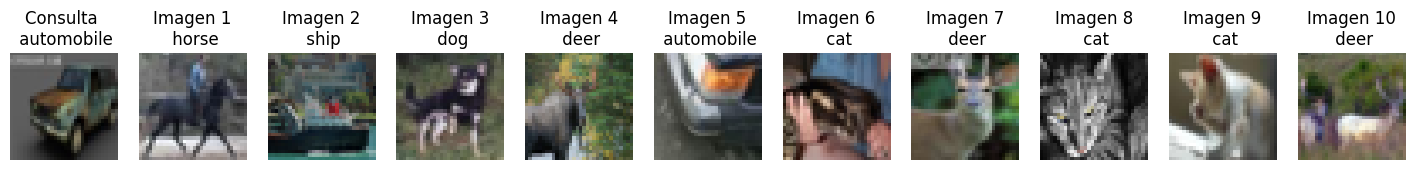

In [61]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

Observamos que usando los histogramas de color, la búsqueda de imágenes no es muy precisa. En este caso, solo ha conseguido acertar una imagen.

#### **3.1.2. Histogramas de textura + KNN**

**Carga de histogramas de textura**

In [62]:
# Cargar los histogramas desde el archivo CSV
df_text = pd.read_csv('caracts_textura.csv')

texturas_bd = df_text.values

**Búsqueda de imágenes similares a la imagen query**

In [63]:
# Cargar la imagen de consulta
imagen_query = imagenes_test[1]
# Calcular caracteristicas de textura de la imagen de consulta
caracts_textura = caract_text(imagen_query).ravel()

# parámetros
k_vecinos = 10
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_KNN(texturas_bd, caracts_textura, k_vecinos, metrica,
                                                                n_imagenes_similares)

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

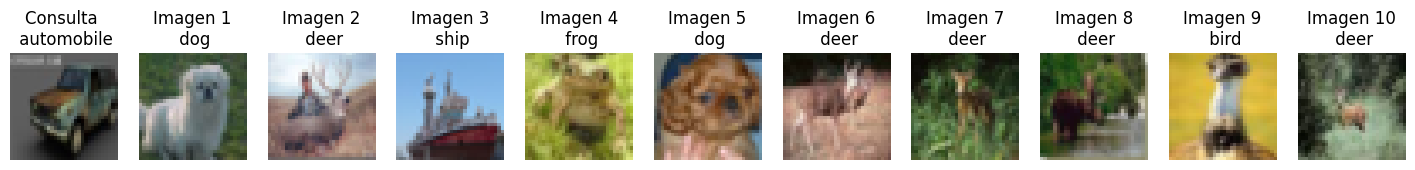

In [64]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

Vemos que los resultados no son buenos.

#### **3.1.3. SIFT + KNN**

Aplicamos la búsqueda de imágenes con VGG19 y KNN.

**Carga de descriptores SIFT**

In [65]:
# cargar los descriptores
df = pd.read_csv('descriptores_sift.csv')

# Convertir el DataFrame de pandas de nuevo a una lista de características
descriptores_sift = df.values

**Búsqueda de imágenes similares a la imagen query**

In [66]:
# Cargar la imagen de consulta y obtener sus características con SIFT
imagen_query = imagenes_test[1]
sift_query = sift(imagen_query)

# MODELO KNN
# parámetros
k_vecinos = 2
metrica = 'euclidean'  # podemos probar con otras medidas
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_KNN(descriptores_sift, sift_query, k_vecinos, metrica, n_imagenes_similares)

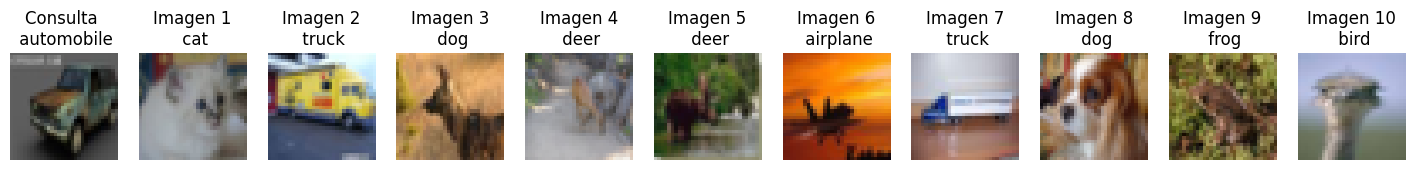

In [67]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

Vemos que no obtenemos buenos resultados porque no nos ha devuelto ninguna imagen de coche.

#### **3.1.4. VGG19 + KNN**

Aplicamos la búsqueda de imágenes con VGG19 y KNN.

**Carga de características VGG19**

In [68]:
df = pd.read_csv('caracteristicas_vgg19.csv')

caracteristicas_vgg19 = df.values

**Búsqueda de imágenes similares a la imagen query**

In [69]:
# Cargar la imagen de consulta y obtener sus características con VGG19
imagen_query = imagenes_test[1]
imagen_query_cargada = cargar_y_preprocesar_imagen(imagen_query)
vgg19_query = modelo_vgg19.predict(imagen_query_cargada)
vgg19_query = vgg19_query.flatten()  # Aplanar las características

# MODELO KNN
# parámetros
k_vecinos = 2
metrica = 'cosine'  # podemos probar con otras medidas
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_KNN(caracteristicas_vgg19, vgg19_query, k_vecinos, metrica, n_imagenes_similares)

1/1 [==============================] - 0s 193ms/step


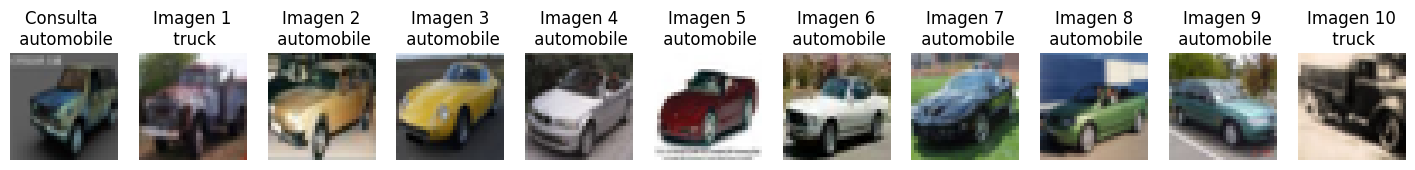

In [70]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(cv2.cvtColor(imagen_query, cv2.COLOR_BGR2RGB))
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

En este caso, vemos que la precisión es mucho mayor que el de los histogramas, pues de las 10 imágenes recuperadas solo ha fallado 2, donde ha sacado imágenes de camiones en vez de coches.

### **3.2. LSH**

**Función que busca imágenes similares a la imagen query**

Toma como parámetros de entrada un array que contiene todos los histogramas de color de las imágenes que tenemos, la imagen de consulta y el número de imágenes similares que queremos obtener.

* **todas_caracteristicas**: son las características de todas las imágenes seleccionadas.
* **caracteristicas_query**: array de características de la imagen query.
* **num_hash_functions**: número de funciones hash.
* **metrica**: medida que se usa para calcular las distancias entre las funciones hash. (Tiene que ser una de las métricas admitidas por el algoritmo LSH).
* **n_imagenes_similares**: número de imágenes que queremos que nos devuelva.


La función nos devuelve una lista de las imágenes similares que se han obtenido.

In [71]:
def buscar_imagenes_LSH(todas_caracteristicas, caracteristicas_query, num_hash_functions, metrica, n_imagenes_similares):
    inicio = time.time()

    # Configuración de LSH
    np.random.seed(42)
    hash_size = todas_caracteristicas.shape[1]
    lsh = LSHash(num_hash_functions, hash_size)

    # Agregar caracteristica a LSH
    for i, caracteristica in enumerate(todas_caracteristicas):
        lsh.index(caracteristica.tolist(), extra_data=i)

    results = lsh.query(caracteristicas_query, num_results=n_imagenes_similares, distance_func=metrica)
    indices = []
    for ((vec,extra_data),distance) in results:
        indices.append(extra_data)

    final = time.time()
    tiempo_ejecucion = final - inicio

    imagenes_similares = [] # sacar las imágenes más similares
    clase_similares = []  # etiquetas de las imágenes sacadas
    for i in indices:
        imagen_similar = imagenes_seleccionadas[i]
        imagenes_similares.append(imagen_similar)

        clase = etiquetas_seleccionadas[i]
        clase_similares.append(clase)
    return imagenes_similares, clase_similares, tiempo_ejecucion

#### **3.2.1. Histogramas de color + LSH**

In [72]:
# Cargar la imagen de consulta
imagen_query = imagenes_test[1]
# Calcular el histograma de color en RGB de la imagen de consulta
hist_query = calcular_histograma_color(imagen_query).ravel()

# parámetros
num_hash_functions = 2  # número de funciones hash
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_LSH(histogramas_base_de_datos, hist_query,
                                                                num_hash_functions, metrica,
                                                                n_imagenes_similares)

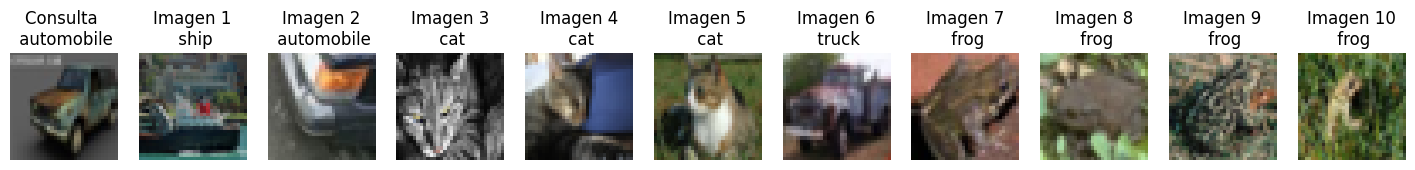

In [73]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

Observamos que tampoco nos arroja muy buenos resultados, ya que solo acierta una imagen.

#### **3.2.2. Histogramas de textura + LSH**

In [74]:
# Cargar la imagen de consulta
imagen_query = imagenes_test[1]
# Calcular el histograma de color en RGB de la imagen de consulta
caracts_textura = caract_text(imagen_query).ravel()

# parámetros
num_hash_functions = 4
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_LSH(texturas_bd, caracts_textura,
                                                                num_hash_functions, metrica,
                                                                n_imagenes_similares)

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

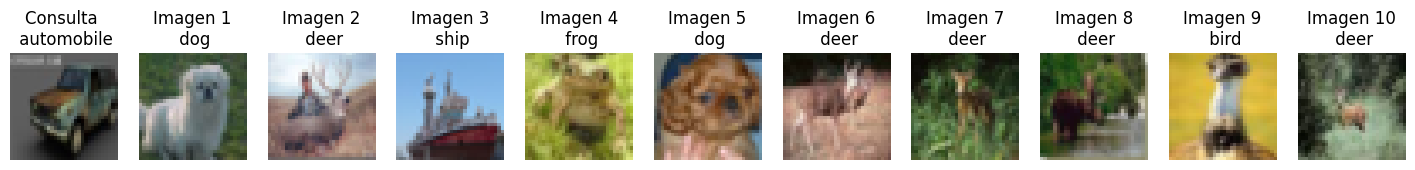

In [75]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

#### **3.2.3. SIFT + LSH**

In [76]:
# Cargar la imagen de consulta y obtener sus características con SIFT
imagen_query = imagenes_test[1]
sift_query = sift(imagen_query)

# parámetros
num_hash_functions = 1
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_LSH(descriptores_sift, sift_query,
                                                                num_hash_functions, metrica,
                                                                n_imagenes_similares)

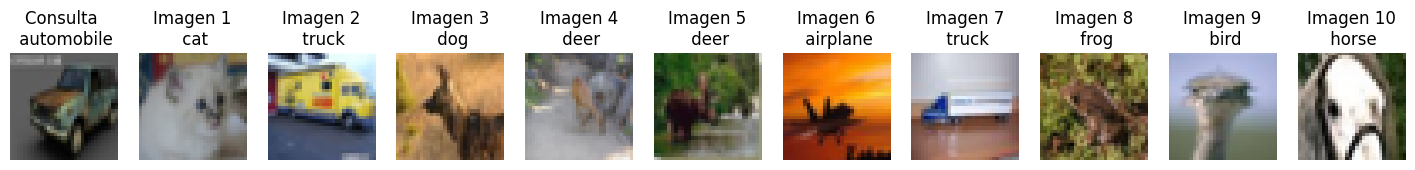

In [78]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

#### **3.2.4. VGG19 + LSH**

In [79]:
# Cargar la imagen de consulta y obtener sus características con VGG19
imagen_query = imagenes_test[1]
imagen_query_cargada = cargar_y_preprocesar_imagen(imagen_query)
vgg19_query = modelo_vgg19.predict(imagen_query_cargada)
vgg19_query = vgg19_query.flatten()  # Aplanar las características

# parámetros
num_hash_functions = 8
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar

# imagenes similares a la imagen query
imagenes_similares, etiquetas_similares,_ = buscar_imagenes_LSH(caracteristicas_vgg19, vgg19_query,
                                                                num_hash_functions, metrica,
                                                                n_imagenes_similares)

1/1 [==============================] - 0s 35ms/step


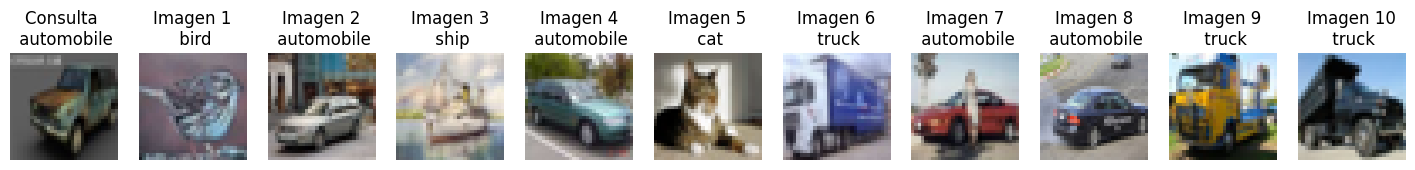

In [81]:
# Plot de las imágenes más similares
fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

# Mostrar la imagen de consulta
axs[0].imshow(imagen_query)
axs[0].set_title(f"Consulta \n {etiquetas_test[1]}")
axs[0].axis('off')

# Mostrar las imágenes más similares
for i, imagen in enumerate(imagenes_similares):
    axs[i + 1].imshow(imagen)
    axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
    axs[i + 1].axis('off')
plt.show()

## **4. Evaluación de modelos**

Se evaluarán sobre 10 imágenes de test (`imagenes_test`): una imagen por cada etiqueta.

### **4.1. Histogramas de color + KNN**

IMAGEN DE CONSULTA 1


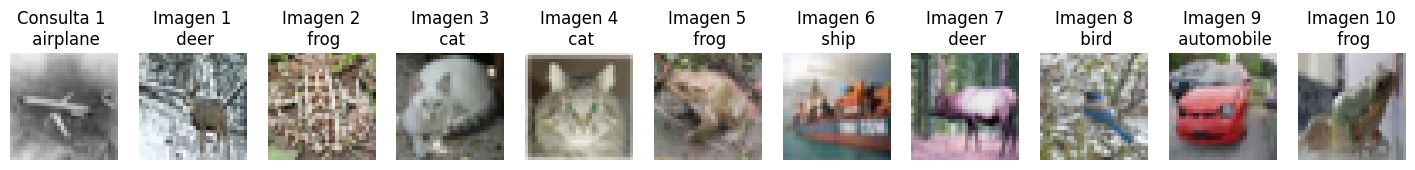

Tiempo de búsqueda de Consulta 1: 0.0062024593353271484 segundos

IMAGEN DE CONSULTA 2


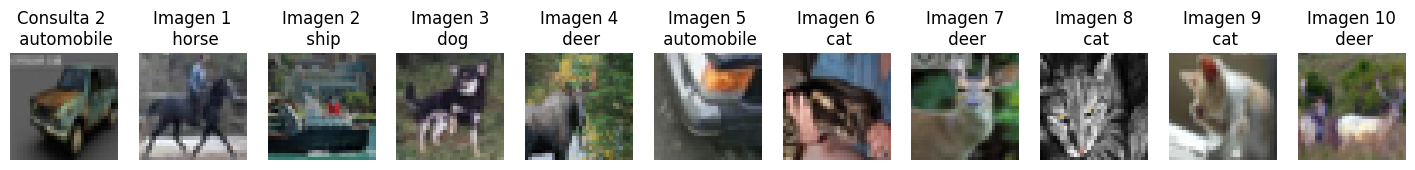

Tiempo de búsqueda de Consulta 2: 0.004172086715698242 segundos

IMAGEN DE CONSULTA 3


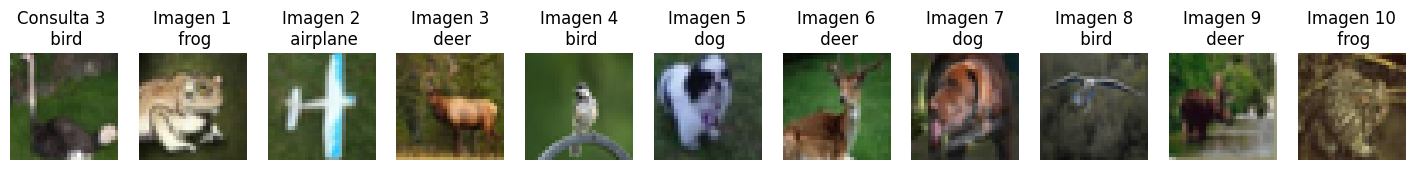

Tiempo de búsqueda de Consulta 3: 0.0022139549255371094 segundos

IMAGEN DE CONSULTA 4


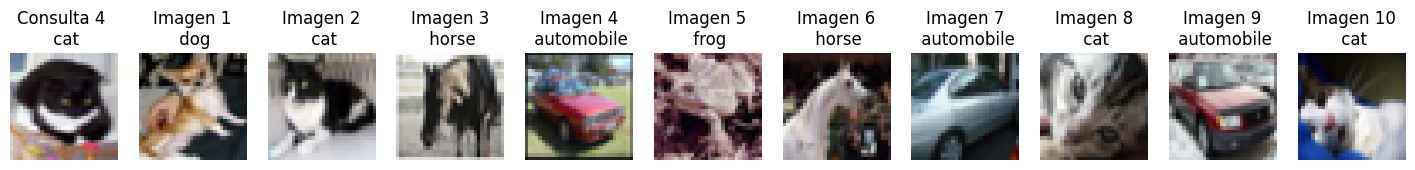

Tiempo de búsqueda de Consulta 4: 0.007671833038330078 segundos

IMAGEN DE CONSULTA 5


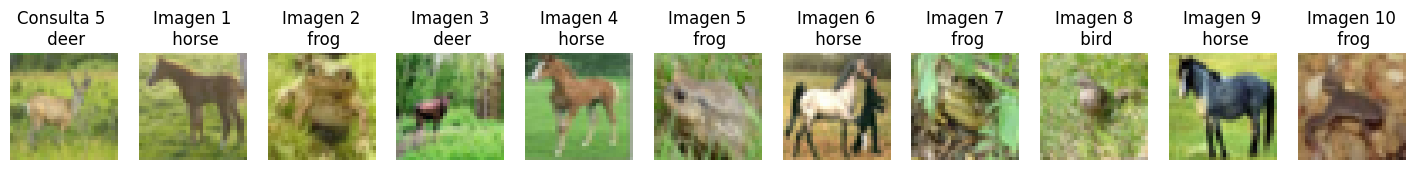

Tiempo de búsqueda de Consulta 5: 0.009846925735473633 segundos

IMAGEN DE CONSULTA 6


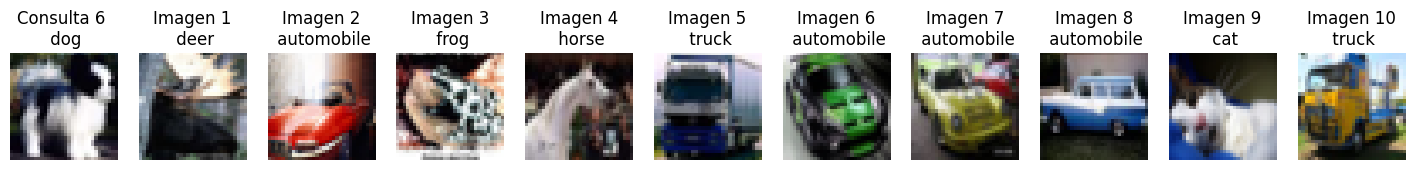

Tiempo de búsqueda de Consulta 6: 0.0021593570709228516 segundos

IMAGEN DE CONSULTA 7


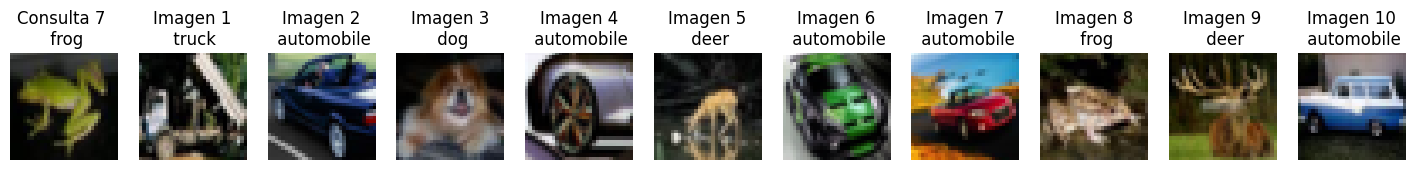

Tiempo de búsqueda de Consulta 7: 0.006033420562744141 segundos

IMAGEN DE CONSULTA 8


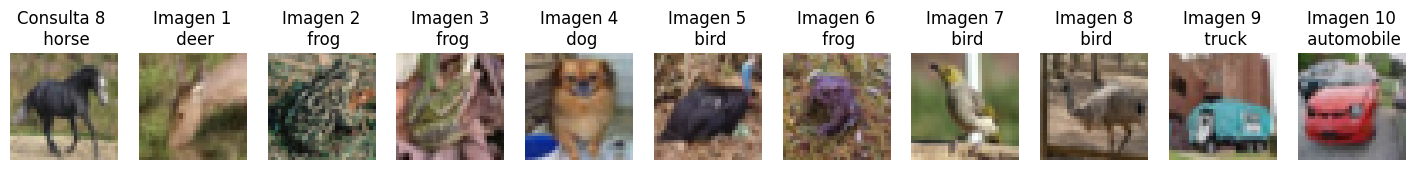

Tiempo de búsqueda de Consulta 8: 0.00638270378112793 segundos

IMAGEN DE CONSULTA 9


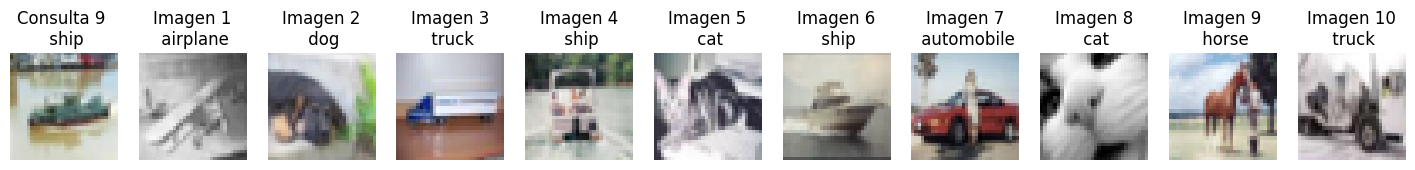

Tiempo de búsqueda de Consulta 9: 0.006131649017333984 segundos

IMAGEN DE CONSULTA 10


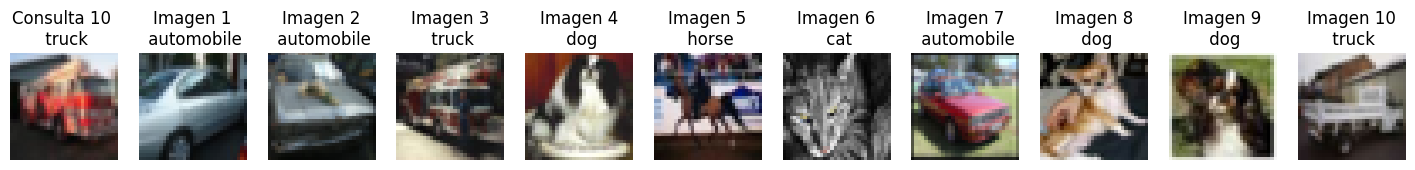

Tiempo de búsqueda de Consulta 10: 0.005680084228515625 segundos

Tiempo promedio de búsqueda: 0.005649447441101074 segundos


In [91]:
# parámetros
k_vecinos = 2
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta
    imagen_query = imagenes_test[j]
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)
    # Calcular el histograma de color en RGB de la imagen de consulta
    hist_query = calcular_histograma_color(imagen_query).ravel()

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_KNN(histogramas_base_de_datos, hist_query, k_vecinos, metrica, n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [99]:
print(f" Accuracy de Histogramas color + KNN: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de Histogramas color + KNN: 0.12


**Conclusión**: el tiempo de búsqueda es bastante bajo, pero la precisión es muy mala.

### **4.2. Histogramas de textura + KNN**

IMAGEN DE CONSULTA 1


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

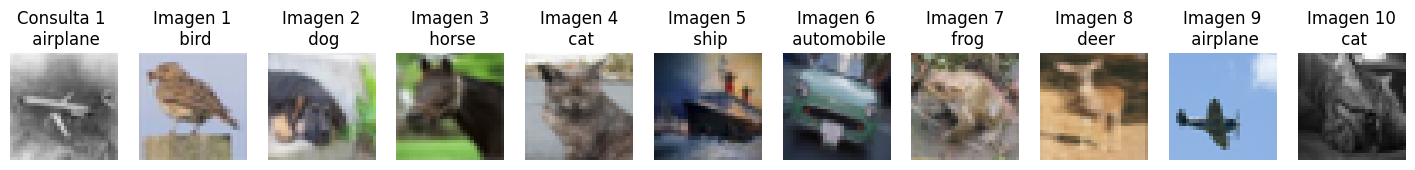

Tiempo de búsqueda de Consulta 1: 0.08097600936889648 segundos

IMAGEN DE CONSULTA 2


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

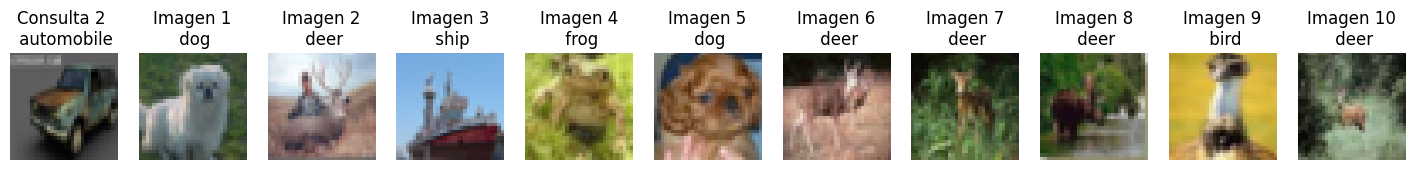

Tiempo de búsqueda de Consulta 2: 0.0008161067962646484 segundos

IMAGEN DE CONSULTA 3


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

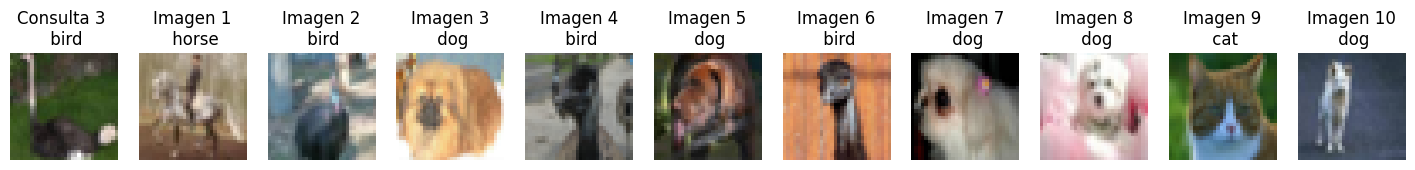

Tiempo de búsqueda de Consulta 3: 0.0009262561798095703 segundos

IMAGEN DE CONSULTA 4


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

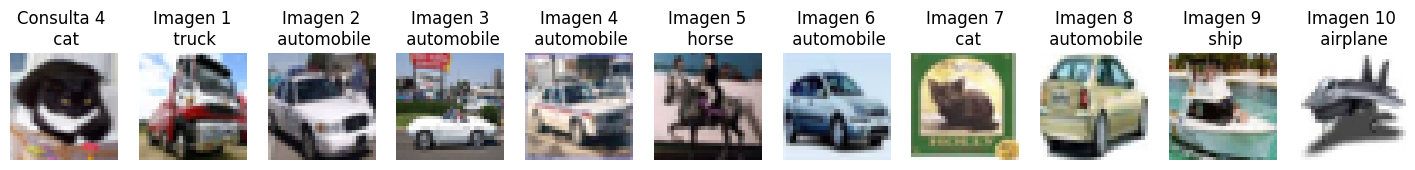

Tiempo de búsqueda de Consulta 4: 0.18528127670288086 segundos

IMAGEN DE CONSULTA 5


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

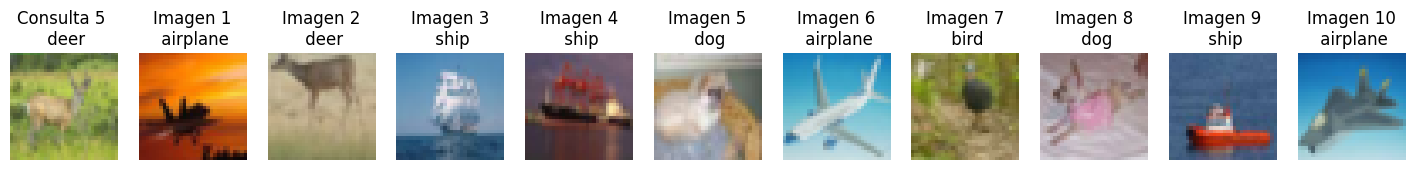

Tiempo de búsqueda de Consulta 5: 0.20080876350402832 segundos

IMAGEN DE CONSULTA 6


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

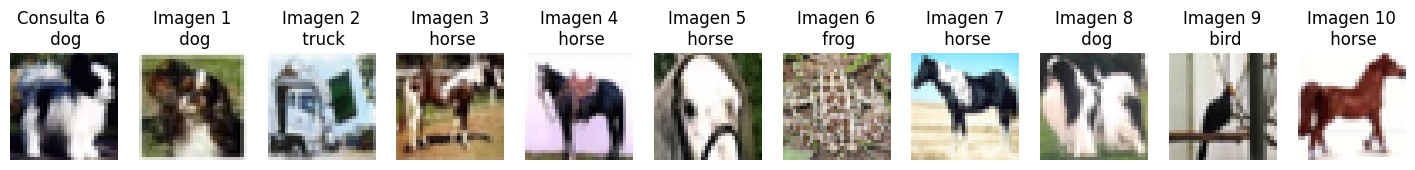

Tiempo de búsqueda de Consulta 6: 0.149949312210083 segundos

IMAGEN DE CONSULTA 7


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

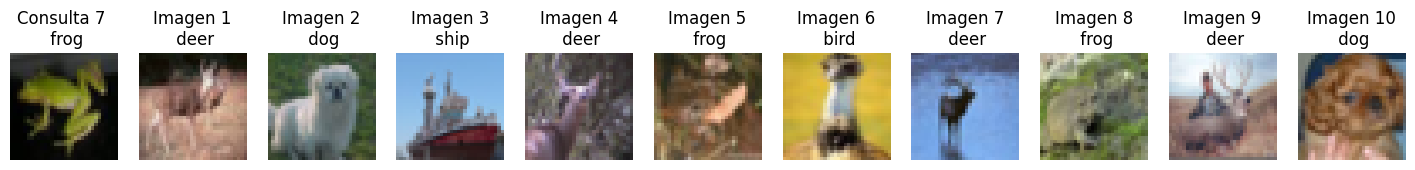

Tiempo de búsqueda de Consulta 7: 0.0018248558044433594 segundos

IMAGEN DE CONSULTA 8


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

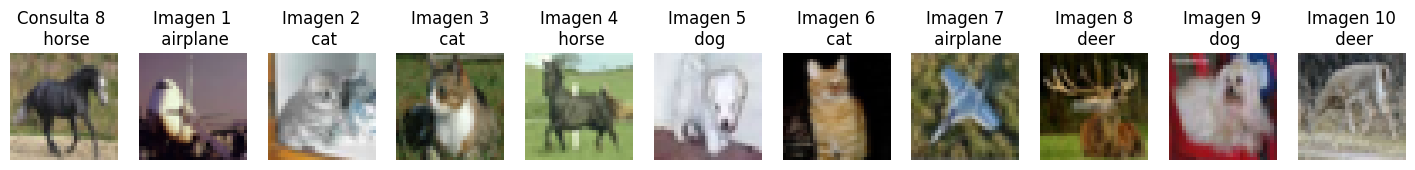

Tiempo de búsqueda de Consulta 8: 0.03570675849914551 segundos

IMAGEN DE CONSULTA 9


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

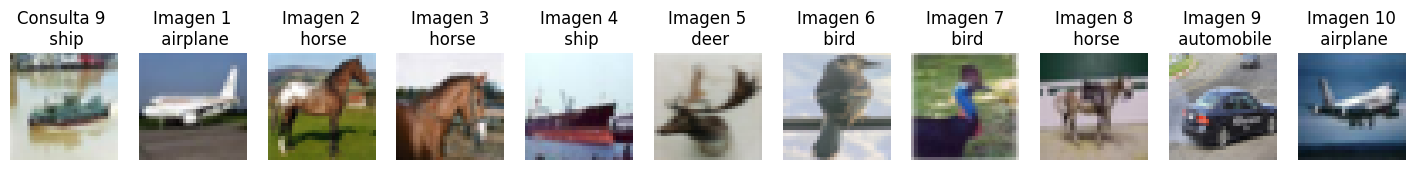

Tiempo de búsqueda de Consulta 9: 0.001081705093383789 segundos

IMAGEN DE CONSULTA 10


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

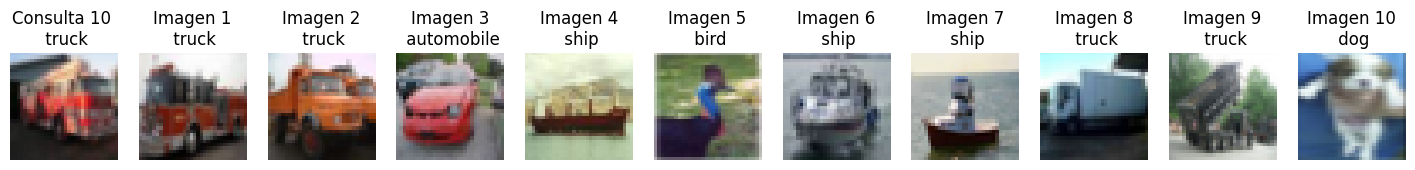

Tiempo de búsqueda de Consulta 10: 0.15718793869018555 segundos

Tiempo promedio de búsqueda: 0.0814558982849121 segundos


In [100]:
k_vecinos = 2
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales

for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')

    imagen_query = imagenes_test[j]
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)
    # Calcular caracteristicas de textura de la imagen de consulta
    caracts_textura = caract_text(imagen_query).ravel()

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_KNN(texturas_bd, caracts_textura, k_vecinos, metrica,
                                                                n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [101]:
print(f" Accuracy de características de textura + KNN: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de características de textura + KNN: 0.16


### **4.3. SIFT + KNN**

IMAGEN DE CONSULTA 1


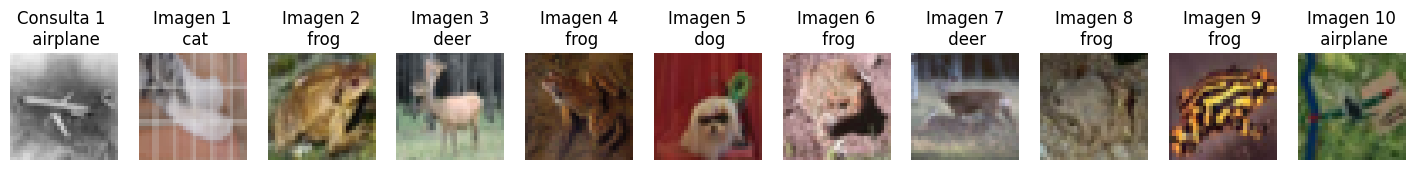

Tiempo de búsqueda de Consulta 1: 0.007448673248291016 segundos

IMAGEN DE CONSULTA 2


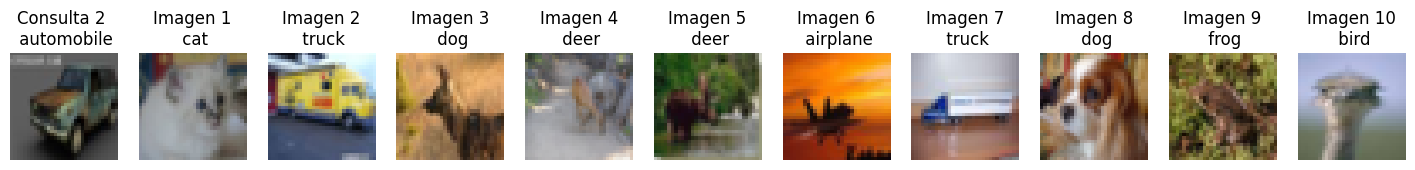

Tiempo de búsqueda de Consulta 2: 0.00958108901977539 segundos

IMAGEN DE CONSULTA 3


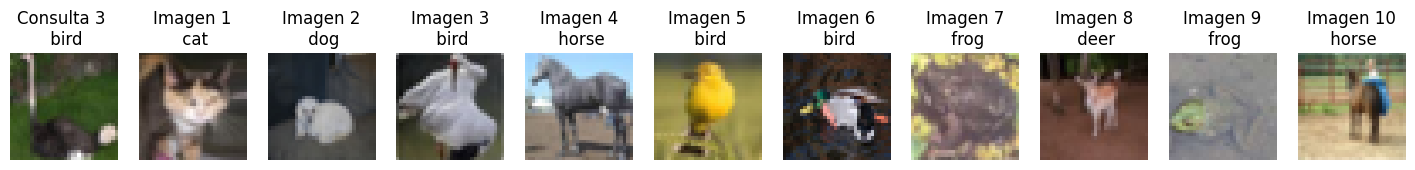

Tiempo de búsqueda de Consulta 3: 0.0020394325256347656 segundos

IMAGEN DE CONSULTA 4


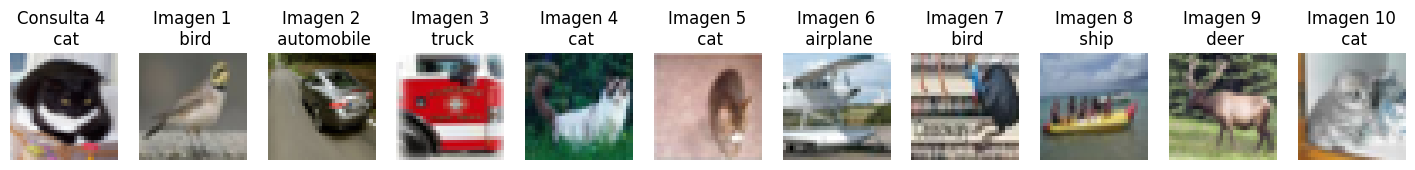

Tiempo de búsqueda de Consulta 4: 0.0016338825225830078 segundos

IMAGEN DE CONSULTA 5


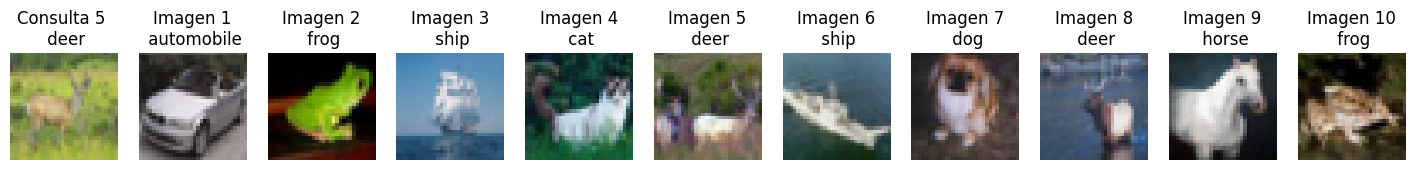

Tiempo de búsqueda de Consulta 5: 0.004937410354614258 segundos

IMAGEN DE CONSULTA 6


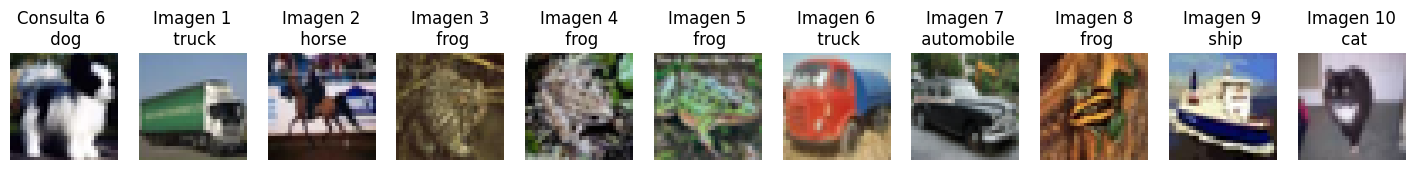

Tiempo de búsqueda de Consulta 6: 0.009005308151245117 segundos

IMAGEN DE CONSULTA 7


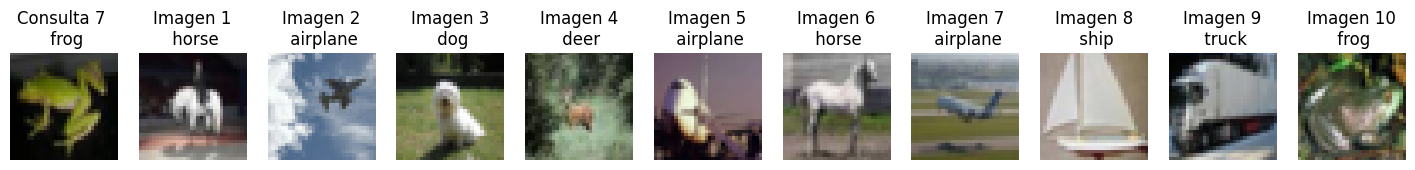

Tiempo de búsqueda de Consulta 7: 0.005585670471191406 segundos

IMAGEN DE CONSULTA 8


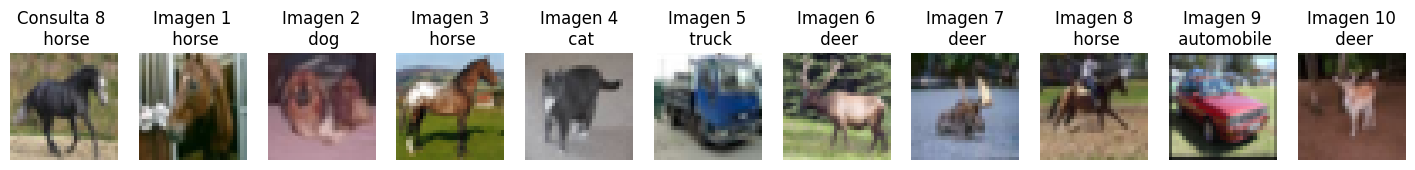

Tiempo de búsqueda de Consulta 8: 0.004773139953613281 segundos

IMAGEN DE CONSULTA 9


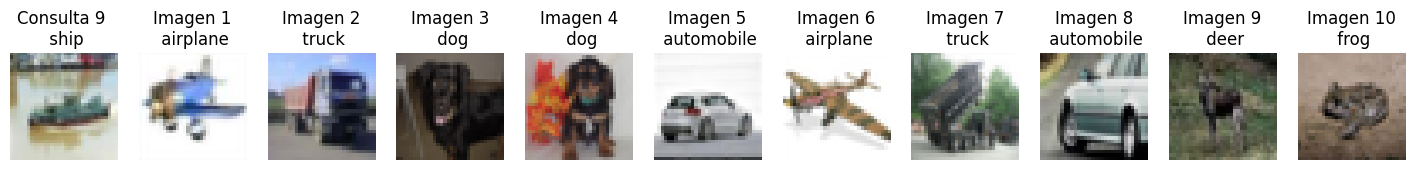

Tiempo de búsqueda de Consulta 9: 0.0027167797088623047 segundos

IMAGEN DE CONSULTA 10


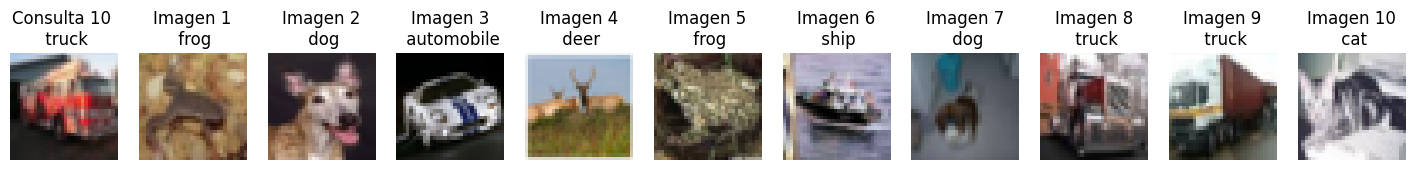

Tiempo de búsqueda de Consulta 10: 0.005066633224487305 segundos

Tiempo promedio de búsqueda: 0.0052788019180297855 segundos


In [113]:
# parámetros
k_vecinos = 2
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta
    imagen_query = imagenes_test[j]
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)
    # Calcular SIFT de la imagen de consulta
    sift_query = sift(imagen_query)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_KNN(descriptores_sift, sift_query, k_vecinos, metrica, n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [114]:
print(f" Accuracy de SIFT + KNN: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de SIFT + KNN: 0.15


Vemos que no obtenemos buenos resultados.

### **4.4. VGG19 + KNN**

IMAGEN DE CONSULTA 1
1/1 [==============================] - 0s 25ms/step


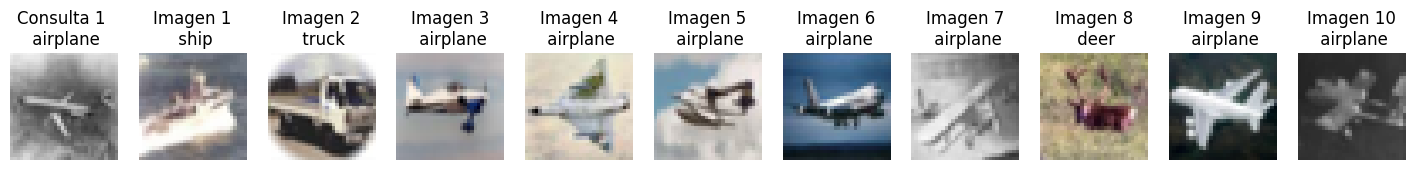

Tiempo de búsqueda de Consulta 1: 0.1689295768737793 segundos

IMAGEN DE CONSULTA 2
1/1 [==============================] - 0s 23ms/step


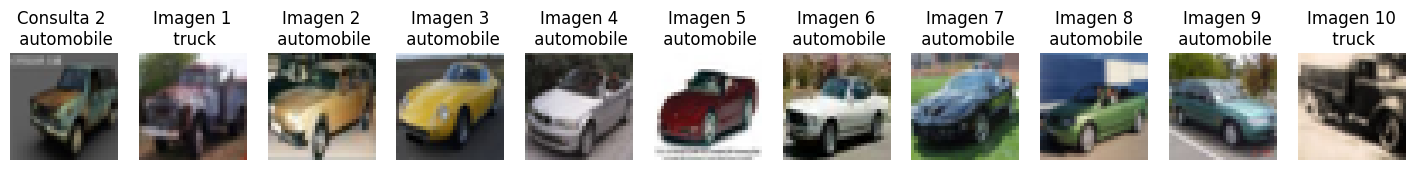

Tiempo de búsqueda de Consulta 2: 0.163038969039917 segundos

IMAGEN DE CONSULTA 3
1/1 [==============================] - 0s 24ms/step


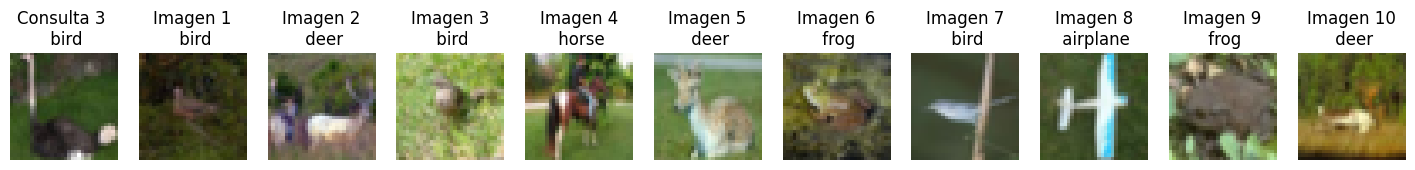

Tiempo de búsqueda de Consulta 3: 0.16259074211120605 segundos

IMAGEN DE CONSULTA 4
1/1 [==============================] - 0s 25ms/step


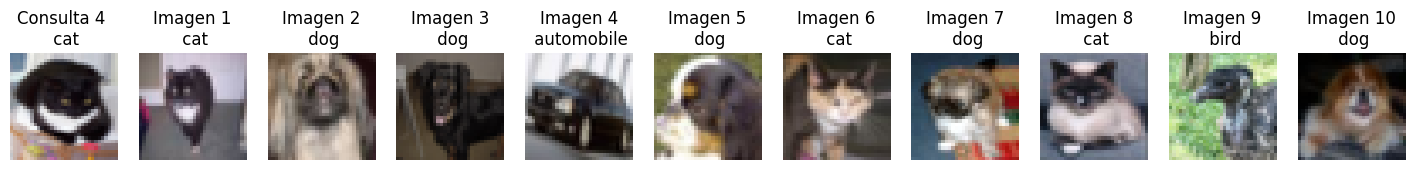

Tiempo de búsqueda de Consulta 4: 0.1573336124420166 segundos

IMAGEN DE CONSULTA 5
1/1 [==============================] - 0s 22ms/step


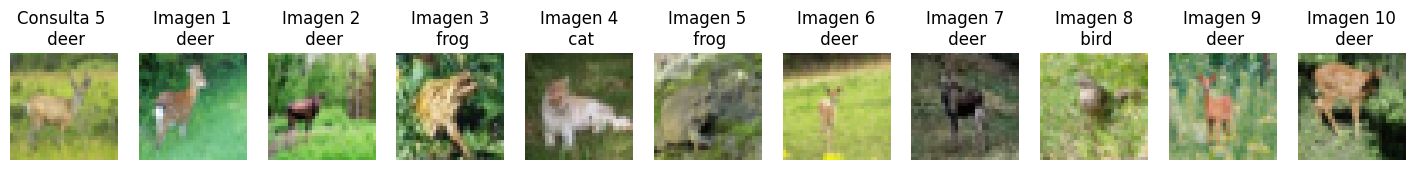

Tiempo de búsqueda de Consulta 5: 0.16586685180664062 segundos

IMAGEN DE CONSULTA 6
1/1 [==============================] - 0s 22ms/step


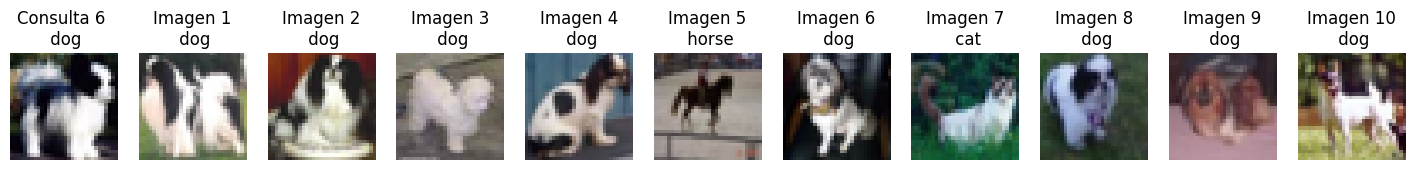

Tiempo de búsqueda de Consulta 6: 0.16212105751037598 segundos

IMAGEN DE CONSULTA 7
1/1 [==============================] - 0s 26ms/step


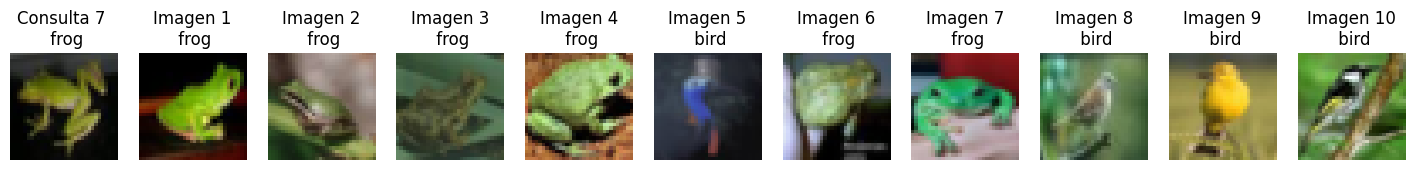

Tiempo de búsqueda de Consulta 7: 0.16595149040222168 segundos

IMAGEN DE CONSULTA 8
1/1 [==============================] - 0s 25ms/step


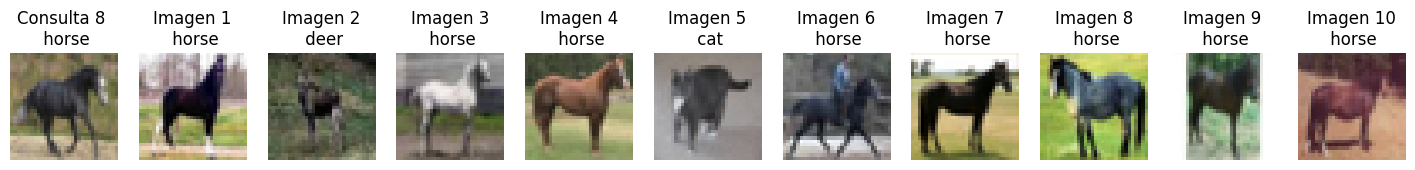

Tiempo de búsqueda de Consulta 8: 0.16054534912109375 segundos

IMAGEN DE CONSULTA 9
1/1 [==============================] - 0s 33ms/step


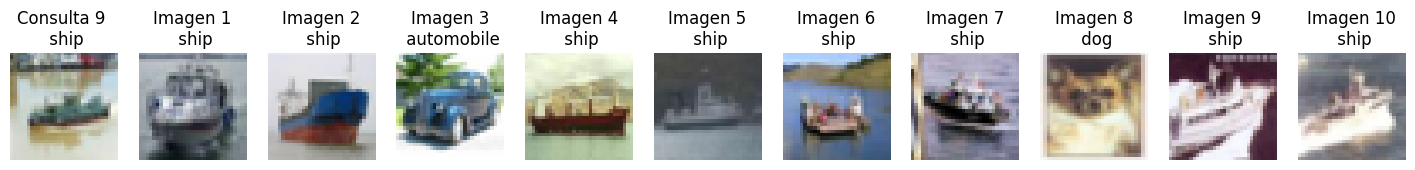

Tiempo de búsqueda de Consulta 9: 0.1747760772705078 segundos

IMAGEN DE CONSULTA 10
1/1 [==============================] - 0s 38ms/step


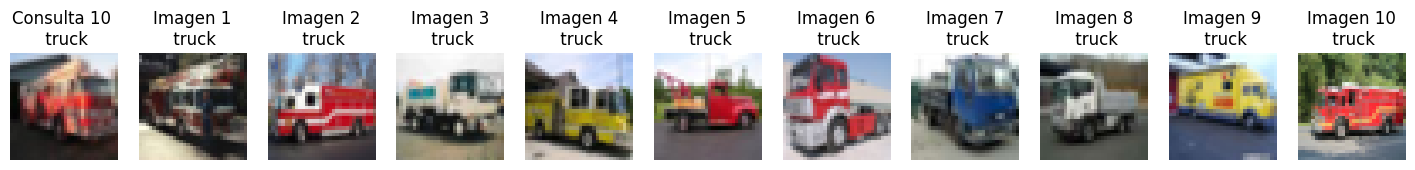

Tiempo de búsqueda de Consulta 10: 0.17844295501708984 segundos

Tiempo promedio de búsqueda: 0.16595966815948487 segundos


In [115]:
# parámetros
k_vecinos = 2
metrica = 'cosine'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta y obtener sus características con VGG19
    imagen_query = imagenes_test[j]
    imagen_query_cargada = cargar_y_preprocesar_imagen(imagen_query)
    vgg19_query = modelo_vgg19.predict(imagen_query_cargada)
    vgg19_query = vgg19_query.flatten()  # Aplanar las características
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares,tiempo_busqueda = buscar_imagenes_KNN(caracteristicas_vgg19, vgg19_query, k_vecinos, metrica, n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [116]:
print(f" Accuracy de VGG19 + KNN: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de VGG19 + KNN: 0.67


### **4.5. Histogramas de color + LSH**

IMAGEN DE CONSULTA 1


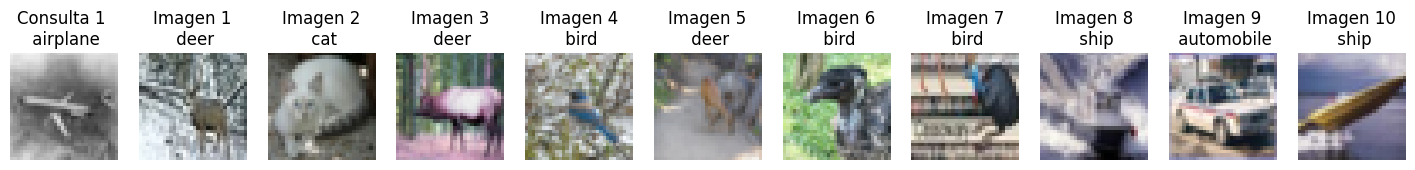

Tiempo de búsqueda de Consulta 1: 0.3202478885650635 segundos

IMAGEN DE CONSULTA 2


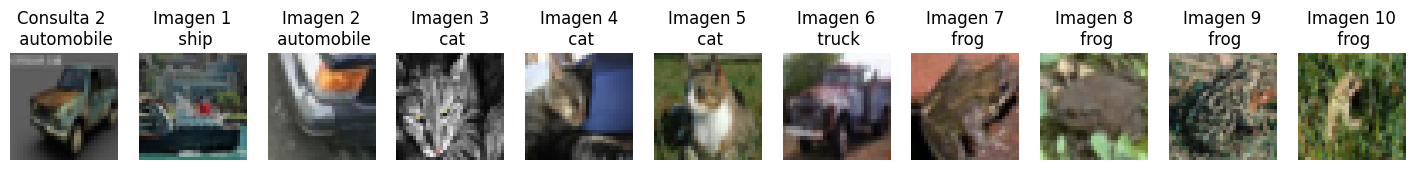

Tiempo de búsqueda de Consulta 2: 0.2674601078033447 segundos

IMAGEN DE CONSULTA 3


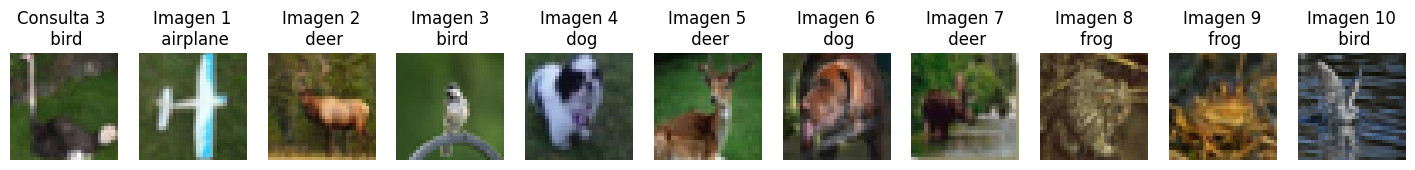

Tiempo de búsqueda de Consulta 3: 0.26369476318359375 segundos

IMAGEN DE CONSULTA 4


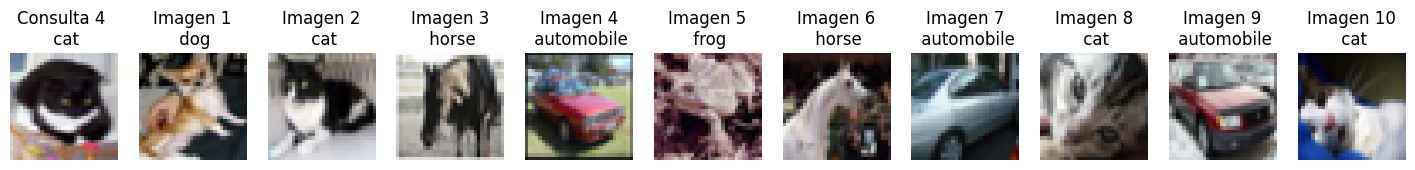

Tiempo de búsqueda de Consulta 4: 0.2737388610839844 segundos

IMAGEN DE CONSULTA 5


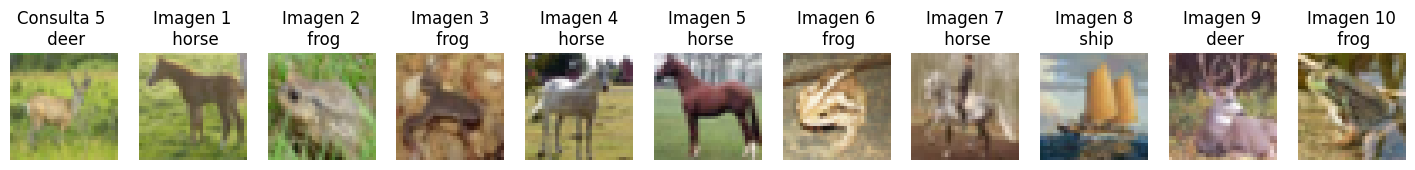

Tiempo de búsqueda de Consulta 5: 0.2892186641693115 segundos

IMAGEN DE CONSULTA 6


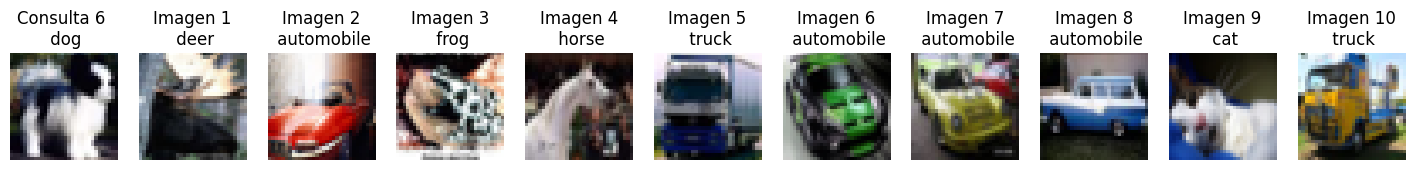

Tiempo de búsqueda de Consulta 6: 0.2560241222381592 segundos

IMAGEN DE CONSULTA 7


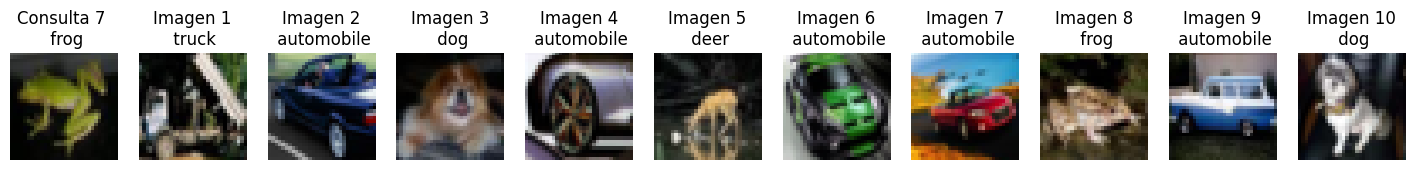

Tiempo de búsqueda de Consulta 7: 0.1747903823852539 segundos

IMAGEN DE CONSULTA 8


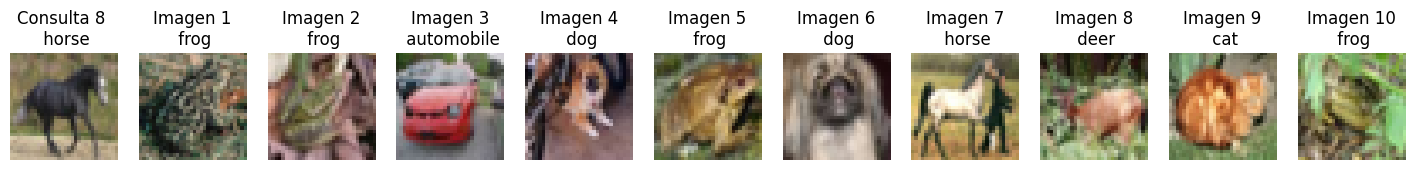

Tiempo de búsqueda de Consulta 8: 0.2495589256286621 segundos

IMAGEN DE CONSULTA 9


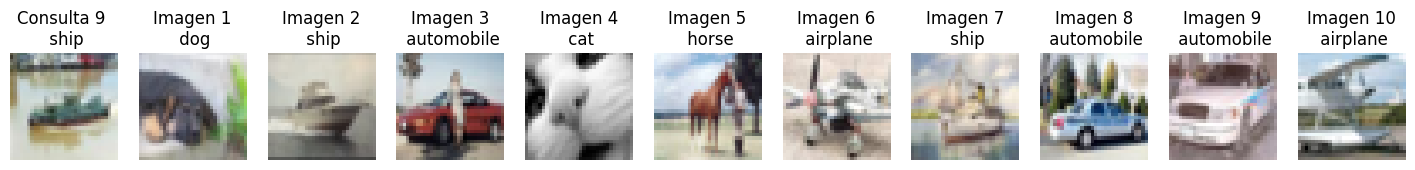

Tiempo de búsqueda de Consulta 9: 0.23738503456115723 segundos

IMAGEN DE CONSULTA 10


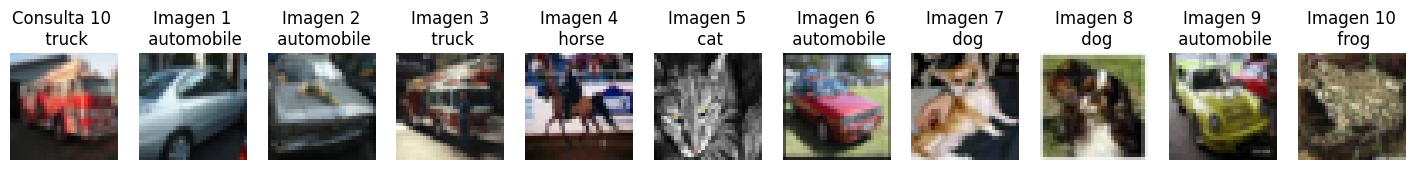

Tiempo de búsqueda de Consulta 10: 0.24214887619018555 segundos

Tiempo promedio de búsqueda: 0.2574267625808716 segundos


In [117]:
# parámetros
num_hash_functions = 1
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta
    imagen_query = imagenes_test[j]
    # Calcular el histograma de color en RGB de la imagen de consulta
    hist_query = calcular_histograma_color(imagen_query).ravel()
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_LSH(histogramas_base_de_datos, hist_query,
                                                                                   num_hash_functions, metrica,
                                                                                   n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [118]:
print(f" Accuracy de Histogramas color + LSH: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de Histogramas color + LSH: 0.12


### **4.6. Histogramas de textura + LSH**

IMAGEN DE CONSULTA 1


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

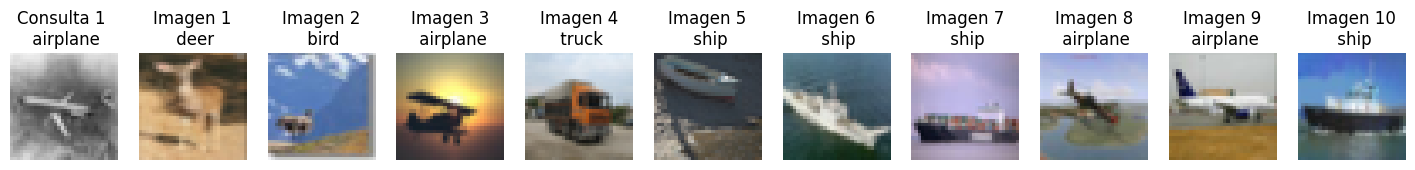

Tiempo de búsqueda de Consulta 1: 0.014969348907470703 segundos

IMAGEN DE CONSULTA 2


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

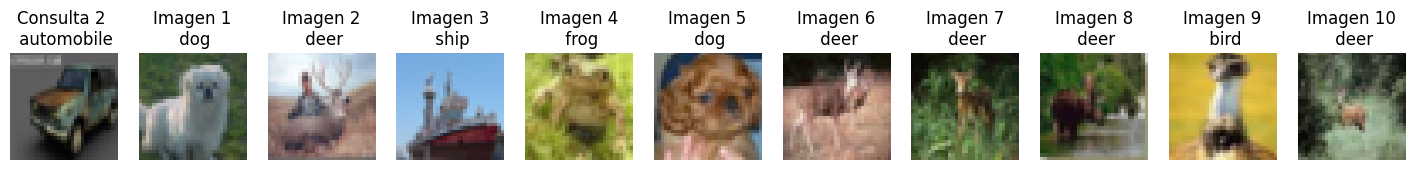

Tiempo de búsqueda de Consulta 2: 0.012778043746948242 segundos

IMAGEN DE CONSULTA 3


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

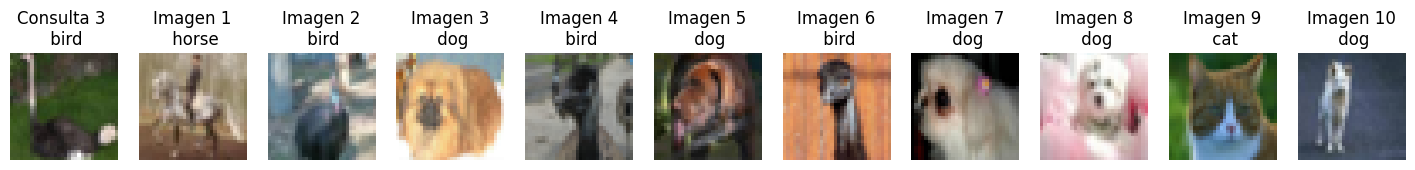

Tiempo de búsqueda de Consulta 3: 0.014652729034423828 segundos

IMAGEN DE CONSULTA 4


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

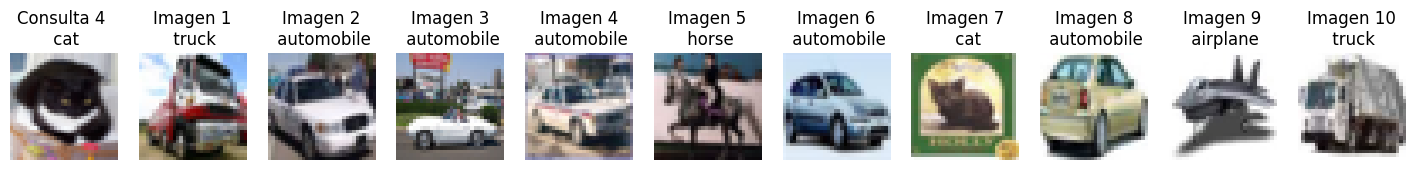

Tiempo de búsqueda de Consulta 4: 0.012640953063964844 segundos

IMAGEN DE CONSULTA 5


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

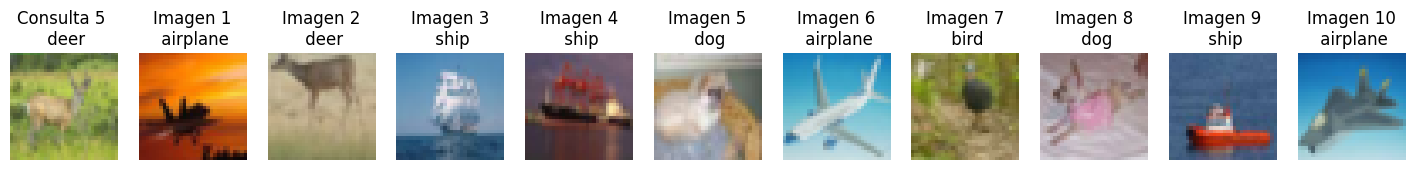

Tiempo de búsqueda de Consulta 5: 0.014586210250854492 segundos

IMAGEN DE CONSULTA 6


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

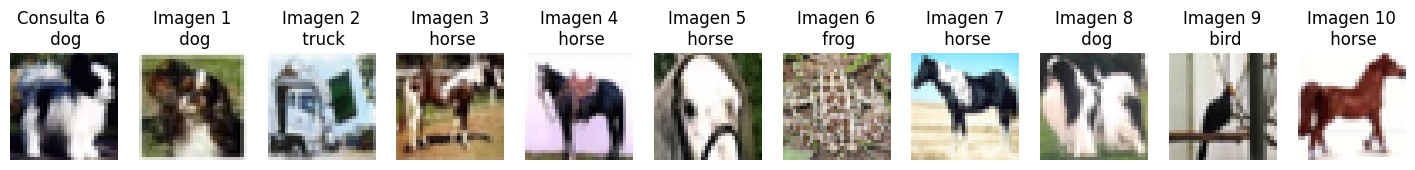

Tiempo de búsqueda de Consulta 6: 0.01938033103942871 segundos

IMAGEN DE CONSULTA 7


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

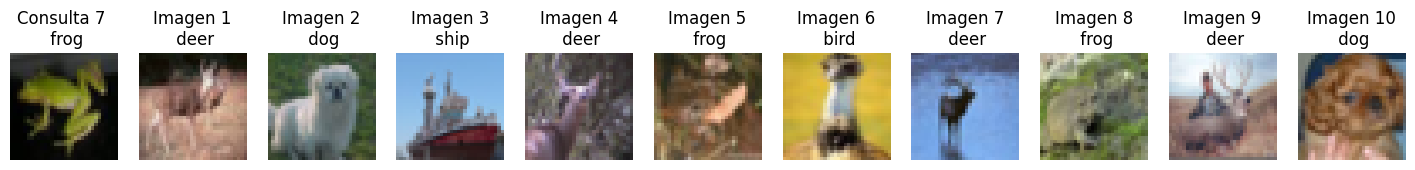

Tiempo de búsqueda de Consulta 7: 0.014194250106811523 segundos

IMAGEN DE CONSULTA 8


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

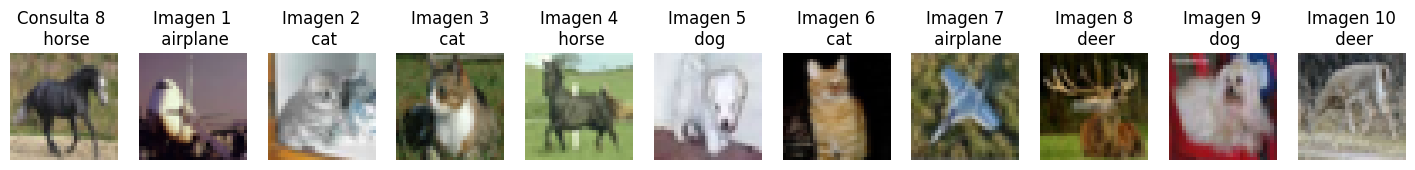

Tiempo de búsqueda de Consulta 8: 0.012675762176513672 segundos

IMAGEN DE CONSULTA 9


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

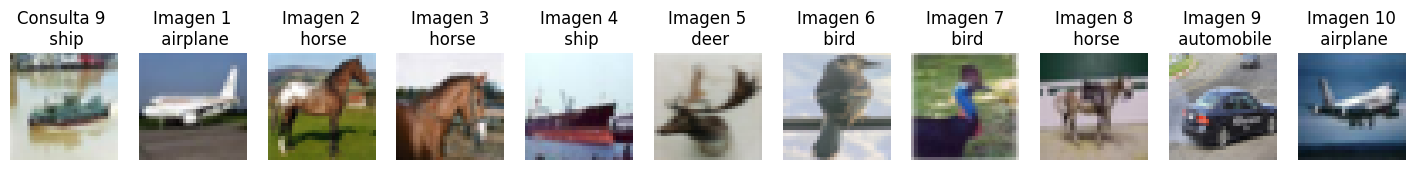

Tiempo de búsqueda de Consulta 9: 0.016181468963623047 segundos

IMAGEN DE CONSULTA 10


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

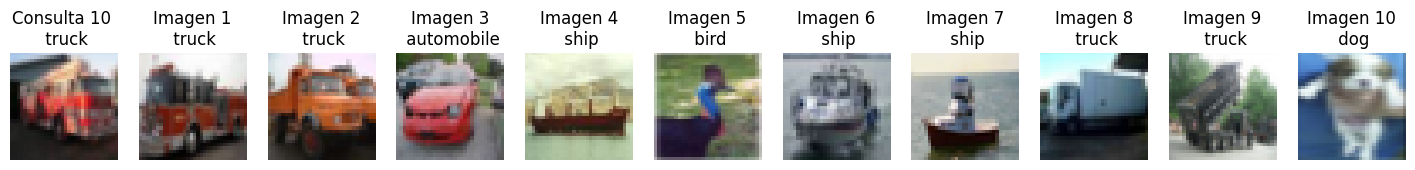

Tiempo de búsqueda de Consulta 10: 0.012458086013793945 segundos

Tiempo promedio de búsqueda: 0.014451718330383301 segundos


In [122]:
# parámetros
num_hash_functions = 4
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta
    imagen_query = imagenes_test[j]
    # Calcular caracteristicas de textura de la imagen de consulta
    caracts_textura = caract_text(imagen_query).ravel()
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_LSH(texturas_bd, caracts_textura,
                                                                                   num_hash_functions, metrica,
                                                                                   n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [123]:
print(f" Accuracy de características de textura + LSH: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de características de textura + LSH: 0.18


### **4.7. SIFT + LSH**

IMAGEN DE CONSULTA 1


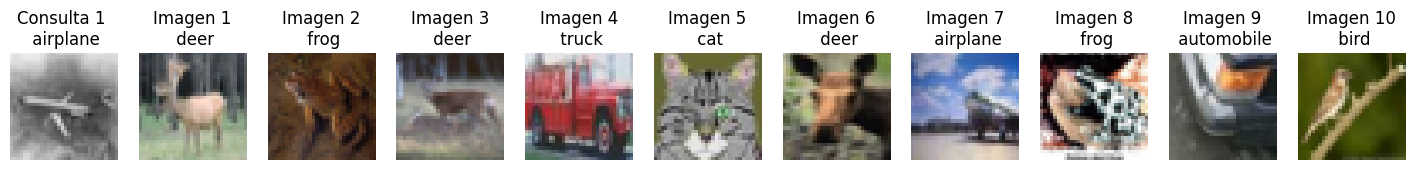

Tiempo de búsqueda de Consulta 1: 0.059912919998168945 segundos

IMAGEN DE CONSULTA 2


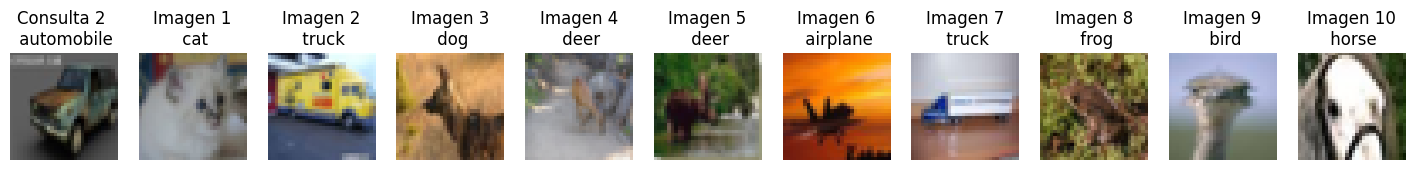

Tiempo de búsqueda de Consulta 2: 0.07846307754516602 segundos

IMAGEN DE CONSULTA 3


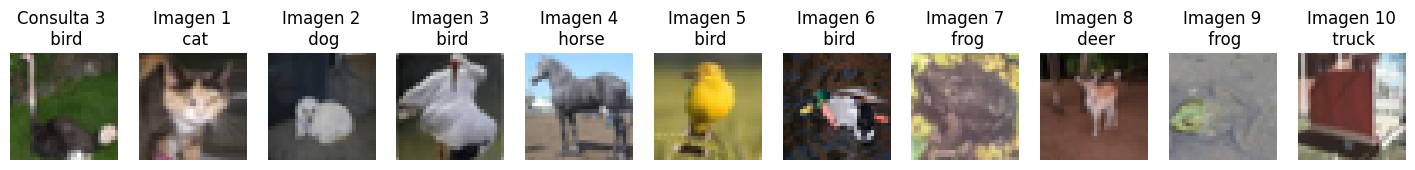

Tiempo de búsqueda de Consulta 3: 0.04978179931640625 segundos

IMAGEN DE CONSULTA 4


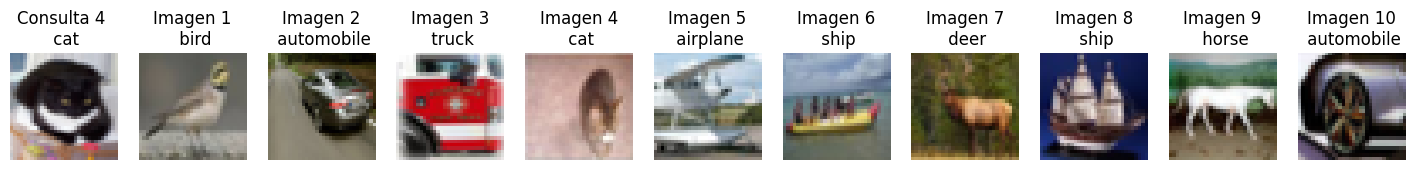

Tiempo de búsqueda de Consulta 4: 0.05851387977600098 segundos

IMAGEN DE CONSULTA 5


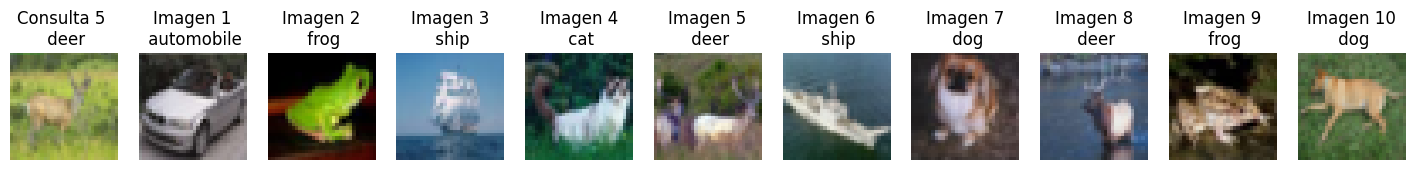

Tiempo de búsqueda de Consulta 5: 0.03580474853515625 segundos

IMAGEN DE CONSULTA 6


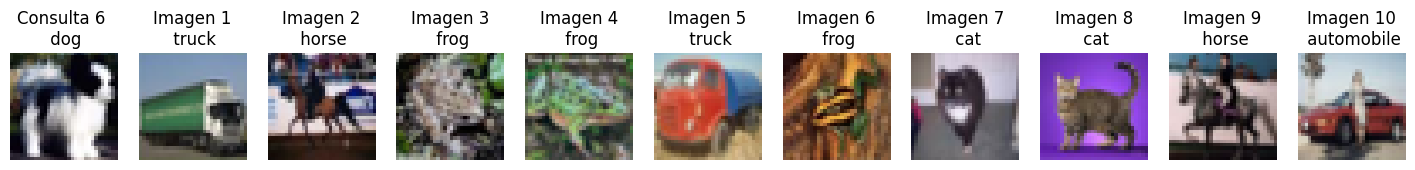

Tiempo de búsqueda de Consulta 6: 0.04631161689758301 segundos

IMAGEN DE CONSULTA 7


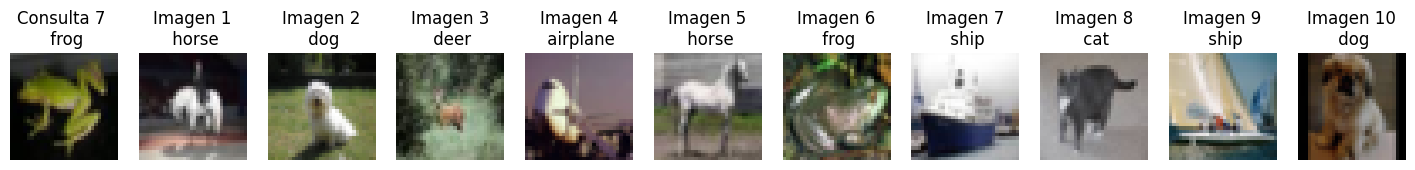

Tiempo de búsqueda de Consulta 7: 0.05089712142944336 segundos

IMAGEN DE CONSULTA 8


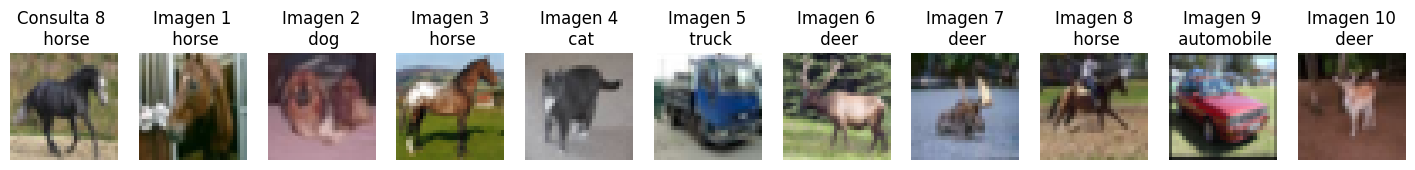

Tiempo de búsqueda de Consulta 8: 0.04226040840148926 segundos

IMAGEN DE CONSULTA 9


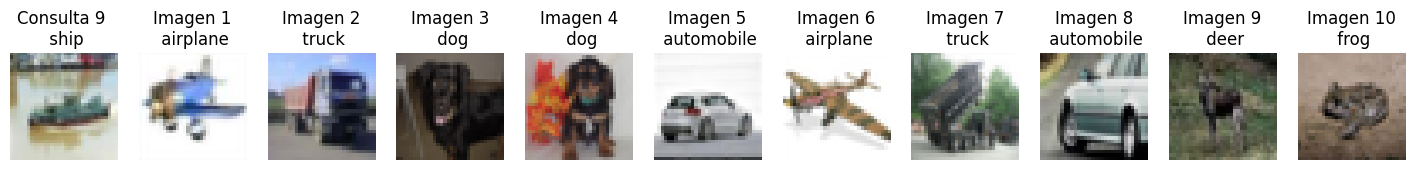

Tiempo de búsqueda de Consulta 9: 0.04859113693237305 segundos

IMAGEN DE CONSULTA 10


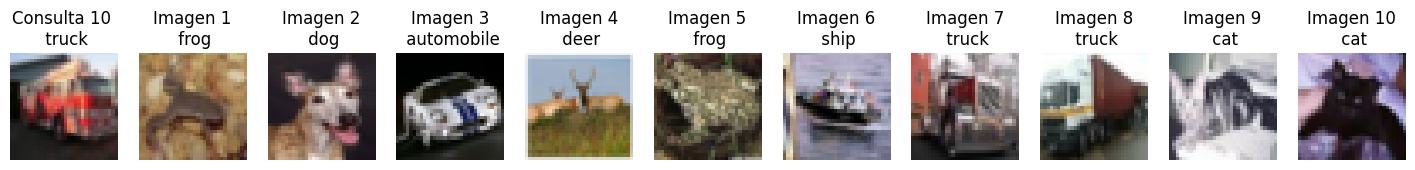

Tiempo de búsqueda de Consulta 10: 0.046805620193481445 segundos

Tiempo promedio de búsqueda: 0.05173423290252686 segundos


In [120]:
# parámetros
num_hash_functions = 1
metrica = 'euclidean'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta
    imagen_query = imagenes_test[j]
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)
    # Calcular SIFT de la imagen de consulta
    sift_query = sift(imagen_query)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_LSH(descriptores_sift, sift_query,
                                                                                   num_hash_functions, metrica,
                                                                                   n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [121]:
print(f" Accuracy de SIFT + LSH: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de SIFT + LSH: 0.13


### **4.8. VGG19 + LSH**

IMAGEN DE CONSULTA 1
1/1 [==============================] - 0s 32ms/step


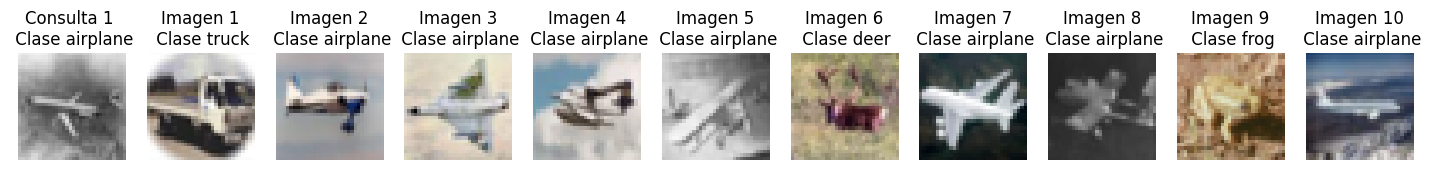

Tiempo de búsqueda de Consulta 1: 16.947295665740967 segundos

IMAGEN DE CONSULTA 2
1/1 [==============================] - 0s 41ms/step


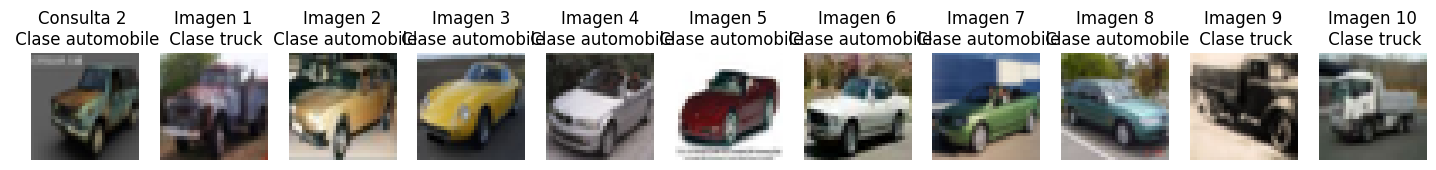

Tiempo de búsqueda de Consulta 2: 11.824097871780396 segundos

IMAGEN DE CONSULTA 3
1/1 [==============================] - 0s 32ms/step


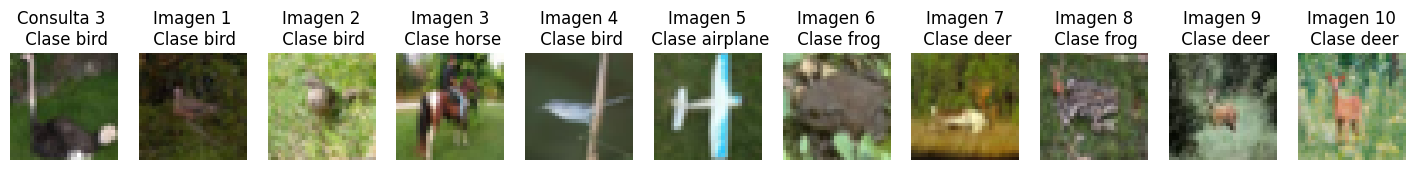

Tiempo de búsqueda de Consulta 3: 9.708688974380493 segundos

IMAGEN DE CONSULTA 4
1/1 [==============================] - 0s 36ms/step


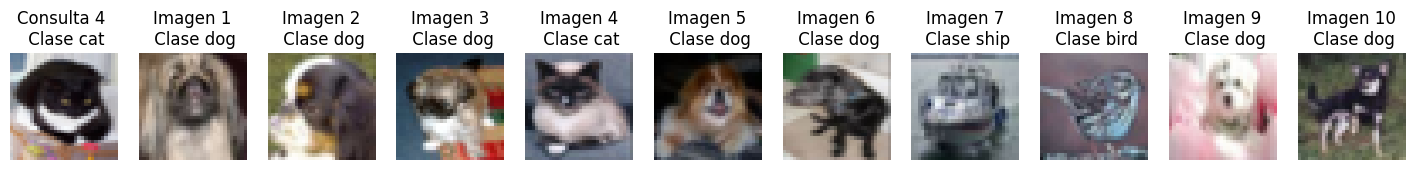

Tiempo de búsqueda de Consulta 4: 11.57475996017456 segundos

IMAGEN DE CONSULTA 5
1/1 [==============================] - 0s 25ms/step


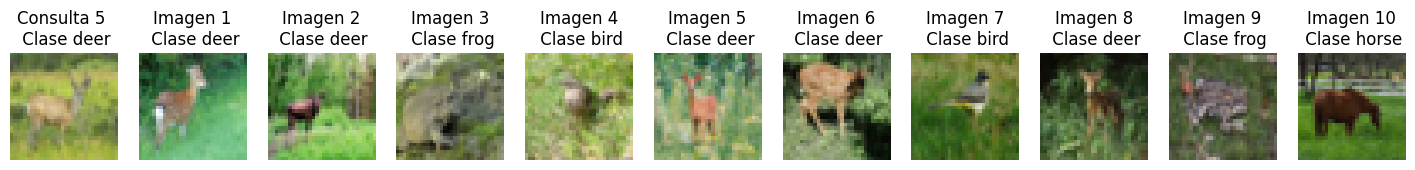

Tiempo de búsqueda de Consulta 5: 15.876279830932617 segundos

IMAGEN DE CONSULTA 6
1/1 [==============================] - 0s 206ms/step


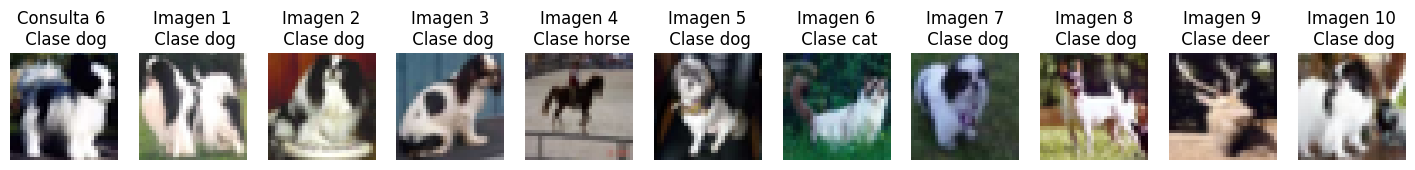

Tiempo de búsqueda de Consulta 6: 21.487245321273804 segundos

IMAGEN DE CONSULTA 7
1/1 [==============================] - 0s 23ms/step


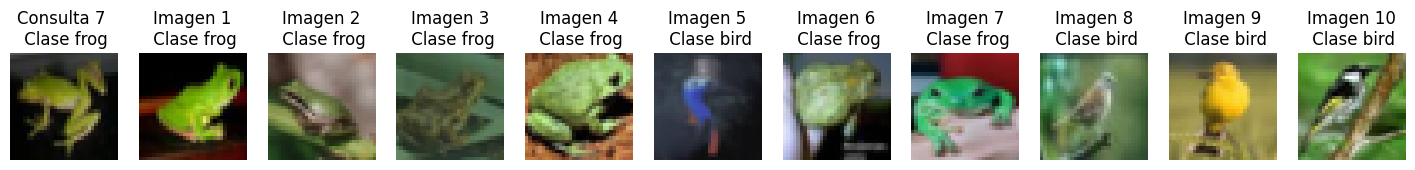

Tiempo de búsqueda de Consulta 7: 11.625751972198486 segundos

IMAGEN DE CONSULTA 8
1/1 [==============================] - 0s 33ms/step


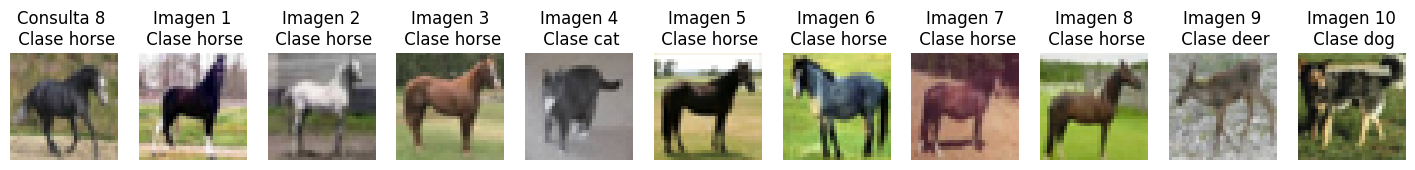

Tiempo de búsqueda de Consulta 8: 13.004421472549438 segundos

IMAGEN DE CONSULTA 9
1/1 [==============================] - 0s 51ms/step


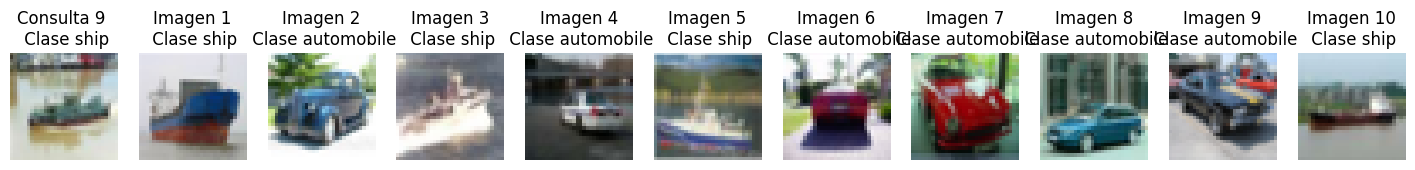

Tiempo de búsqueda de Consulta 9: 12.056449890136719 segundos

IMAGEN DE CONSULTA 10
1/1 [==============================] - 0s 26ms/step


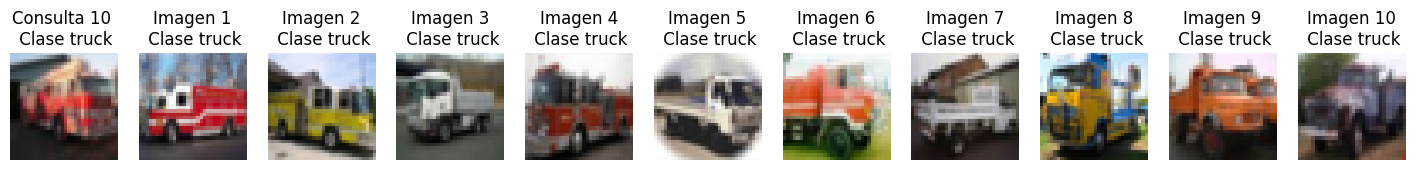

Tiempo de búsqueda de Consulta 10: 7.704413890838623 segundos

Tiempo promedio de búsqueda: 13.18094048500061 segundos


In [111]:
# parámetros
num_hash_functions = 1
metrica = 'cosine'
n_imagenes_similares = 10 # número de imágenes similares que queremos sacar
tiempos_bus = []

etiquetas_pred =[]  # etiquetas de las imágenes similares
etiquetas_true = []  # etiquetas reales
for j in range(len(imagenes_test)):
    print(f'IMAGEN DE CONSULTA {j+1}')
    # Cargar la imagen de consulta y obtener sus características con VGG19
    imagen_query = imagenes_test[j]
    imagen_query_cargada = cargar_y_preprocesar_imagen(imagen_query)
    vgg19_query = modelo_vgg19.predict(imagen_query_cargada)
    vgg19_query = vgg19_query.flatten()  # Aplanar las características
    etiquetas_true.append([etiquetas_test[j]] * n_imagenes_similares)

    # imagenes similares a la imagen query
    imagenes_similares, etiquetas_similares, tiempo_busqueda = buscar_imagenes_LSH(caracteristicas_vgg19, vgg19_query,
                                                                                   num_hash_functions, metrica,
                                                                                   n_imagenes_similares)
    etiquetas_pred.append(etiquetas_similares)
    tiempos_bus.append(tiempo_busqueda)

    # Plot de las imágenes más similares
    fig, axs = plt.subplots(1, n_imagenes_similares+1, figsize=(18, 6))

    # Mostrar la imagen de consulta
    axs[0].imshow(imagen_query)
    axs[0].set_title(f"Consulta {j+1} \n {etiquetas_test[j]}")
    axs[0].axis('off')

    # Mostrar las imágenes más similares
    for i, imagen in enumerate(imagenes_similares):
        axs[i + 1].imshow(imagen)
        axs[i + 1].set_title(f"Imagen {i + 1}\n {etiquetas_similares[i]}")
        axs[i + 1].axis('off')
    plt.show()
    print(f"Tiempo de búsqueda de Consulta {j+1}: {tiempo_busqueda} segundos")
    print()

print(f"Tiempo promedio de búsqueda: {np.mean(tiempos_bus)} segundos")

In [112]:
print(f" Accuracy de VGG19 + LSH: {accuracy_score(list(chain(*etiquetas_true)), list(chain(*etiquetas_pred)))}")

 Accuracy de VGG19 + LSH: 0.57


Observamos que tiene un accuracy mayor que el $50\%$, pero nos quedamos con el modelo de KNN, pues es el que ha obtenido un mayor *accuracy* de todos.